# Initial Exploratory Data Analysis for the HR Separation (hrsepara) project
## Identify the correct working directory for source data
* '/data/discovery/hrsepara/core/'
## Identify the correct working directory for the analysis (both HDFS and LFS)
* '/data/discovery/hrsepara/staging/eda' and  '/home/kesj/working/hrsepara/eda/'
## begin to summarize data 


In [1]:
coredir = '/data/discovery/hrsepara/core/'
stgdir1 = '/data/discovery/hrsepara/staging/eda'
stgdir1local = '/home/kesj/work/hrsepara/eda'


In [2]:
import os,subprocess
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from itertools import chain
import random

/opt/anaconda/2.3.0/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
plt.style.use('fivethirtyeight') # Good looking plots
import seaborn as sns

/opt/anaconda/2.3.0/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
# check if the path exists
os.path.exists(stgdir1local)

True

In [5]:
def hdfs_path_doesnt_exist(path):
    return subprocess.call(['hdfs','dfs','-ls',path])
    # returns 0 if doesnt_exist; 1 otherwise
    

In [6]:
# make the remote directory
if not hdfs_path_doesnt_exist(stgdir1):
    !hdfs dfs -mkdir {stgdir1}

mkdir: `/data/discovery/hrsepara/staging/eda': File exists


In [7]:
# check if the path exists
if not os.path.exists(stgdir1local):
    # make the local directory
    !mkdir {stgdir1local}
    #'/home/kesj/work/hrsepara/eda'


%pwd
%cd {stgdir1local}
#define the currentworking directory:
cwd = os.path.abspath(os.curdir)
print cwd

/home/kesj/work/hrsepara/eda
/home/kesj/work/hrsepara/eda


## Look at the files in {coredir}

In [8]:
fnames = !hdfs dfs -ls {coredir}
infilenames = [f.split()[-1] for f in fnames[1:]]
print len(infilenames)
infilenames

16


['/data/discovery/hrsepara/core/EAS',
 '/data/discovery/hrsepara/core/EMPL',
 '/data/discovery/hrsepara/core/HISTCURR',
 '/data/discovery/hrsepara/core/HISTRET',
 '/data/discovery/hrsepara/core/HISTRETold',
 '/data/discovery/hrsepara/core/SBR',
 '/data/discovery/hrsepara/core/SR_BENEFIT.txt',
 '/data/discovery/hrsepara/core/SR_CKE.txt',
 '/data/discovery/hrsepara/core/SR_COMP.txt',
 '/data/discovery/hrsepara/core/SR_CPR.txt',
 '/data/discovery/hrsepara/core/SR_EAS.txt',
 '/data/discovery/hrsepara/core/SR_EDU.txt',
 '/data/discovery/hrsepara/core/SR_INS.txt',
 '/data/discovery/hrsepara/core/SR_LANG.txt',
 '/data/discovery/hrsepara/core/SR_LIC.txt',
 '/data/discovery/hrsepara/core/SR_RELO.txt']

### helper functions

In [9]:
## function to load into pandas from hdfs (by copying to local filespace)
def pandas_read_hdfs(infile,sep = ';',dtype_dict = None):
    # copy the infile to the cwd
    !hdfs dfs -get {infile} .
    # identify the local file name
    inname = infile[infile.rfind('/')+1:]
    # read into a data frame
    if dtype_dict != None:
        df = pd.read_csv(inname,sep=sep,dtype =dtype_dict)
    else:
        df = pd.read_csv(inname,sep=sep)
    # clean up local filespace
    !rm {inname}
    return df

#
def summarize_dataframe2(df,show_example=False,verbose=False):
    nrow = len(df)
    summary_df = pd.DataFrame(columns = ['Column','datatype','nmissing','arity','accepted values'])
    len_df = len(summary_df)
    for col in df.columns:
        nmiss = nrow - df[col].value_counts().sum()
        narity = len(df[col].unique())
        if show_example:
            print col, df[col].dtype,nmiss, "\t", narity,":\t", df[col].ix[8320]
        elif verbose:
            print col, df[col].dtype,nmiss, "\t", narity
        accept_val = None
        if narity < 20:
            accept_val = df[col].unique()
        summary_df.loc[len_df] = [col,df[col].dtype,nmiss,narity,accept_val]
        len_df+=1
    # assing fraction of missing
    summary_df['x_missing'] = summary_df['nmissing']/float(nrow)
    
    return summary_df

## Load the original EMPL data

In [11]:
empl_df = pandas_read_hdfs(infilenames[1],dtype_dict={'KEY':np.str})
empl_df.shape

(334162, 20)

In [12]:
sdf_empl = summarize_dataframe2(empl_df)

In [13]:
sdf_empl


,Column,datatype,nmissing,arity,accepted values,x_missing
0,KEY,object,0,334162,None,0.000000
1,STATE,object,226,80,None,0.000676
2,ADDRESS1,object,182,308612,None,0.000545
3,ADDRESS2,object,311577,11543,None,0.932413
4,POSTAL_SFI,object,240,65409,None,0.000718
5,HIRE_DT,object,6,15467,None,0.000018
6,LAST_HIRE_DT,object,5,14695,None,0.000015
7,SERVICE_DT,object,0,19150,None,0.000000
8,SEX,object,0,3,"[M, F, U]",0.000000
9,MAR_STA_SNAME_SFI,object,0,3,"[SINGLE, MARRIED, LEG SEPAR]",0.000000


## Define types for specific columns

In [14]:
hist_record_dtype_dict = {'KEY':np.str,'LOCATION':np.str,'EEO1CODE':np.str,'SKEY':np.str,'JOBCODE':np.str,'EMPL_CLASS':np.str, 
                          'SHIFT':np.str,'COMPANY':np.str,'EXT_FUNC_ID_SFI':np.str,'FUNC_ID_SFI':np.str,
                          'DIVISION_CODE_SFI':np.str,'JOB_FAMILY':np.str,'JOB_FUNCTION':np.str,'ACTRES1':np.str,
                          'ACTRES2':np.str,'ACTRES3':np.str,'ACTRES4':np.str,'ACTRES5':np.str,'ACTRES6':np.str,
                          'ACTRES7':np.str,'ACTRES8':np.str,'ACTRES9':np.str,'ACTRES10':np.str,'BOX1':np.str,
                          'BOX2':np.str,'BOX3':np.str,'BOX4':np.str,'BOX5':np.str,'BOX6':np.str,'BOX7':np.str,
                          'BOX8':np.str,'BOX9':np.str,'BOX10':np.str,'RATE1':np.str,'RATE2':np.str,'RATE3':np.str,
                          'RATE4':np.str,'RATE5':np.str,'RATE6':np.str,'RATE7':np.str,'RATE8':np.str,'RATE9':np.str,
                          'RATE10':np.str}
#,'COUNT':np.float,'FUNC_CNT':np.float}
#dictionary to load the histcurr and histret columns the same way

## rename the last 2 columns of HISTCURR to match HISTRET

In [15]:
histcurr_df = pandas_read_hdfs(infilenames[2],dtype_dict=hist_record_dtype_dict)
print histcurr_df.shape#, histcurr_df.columns
# rename the last two columns to match histret
histcurr_df.rename(columns = {'COUNT':'FUNC_CNT','COUNT.1':'EXTFUNC_CNT'},inplace=True)

(70609, 159)


### load the updated HISTRET file from HDFS

In [16]:
histret_df = pandas_read_hdfs(infilenames[3],dtype_dict=hist_record_dtype_dict)
histret_df.shape#,histret_df.columns

(172554, 160)

In [17]:
histret_df.VOLINVOL.value_counts()

VOLUNTARY      110899
INVOLUNTARY     60663
UNKNOWN           501
OTHER             491
Name: VOLINVOL, dtype: int64

#### add a column to histcurr_df corresponding to the new  VOLINVOL column:
* value is 'NOT'

In [18]:
histcurr_df['VOLINVOL'] = 'NOT'

## how many in histret have missing end dates?

In [19]:
histret_df['TERMINATION_DT'].isnull().sum()

73

In [22]:
[cname for cname in histcurr_df.columns if cname.endswith('DT')]

['TERMINATION_DT']

In [25]:
missing_termination_empl_keys = histret_df[histret_df['TERMINATION_DT'].isnull()].KEY.tolist()

#### remove these employees

In [28]:
empl_df[empl_df['KEY'].isin(missing_termination_empl_keys)][['HIRE_DT' ,'BIRTHDATE']]

,HIRE_DT,BIRTHDATE
3076,18OCT1979,09MAY1937
5070,10FEB1964,21OCT1916
5757,08APR1968,29OCT1939
9477,07DEC1987,08MAY1942
13235,12JUN1967,26JAN1942
16628,01MAR1979,20SEP1945
18413,08OCT1957,06JUL1938
18557,24MAY1976,16JUL1943
19750,17APR1969,01MAR1941
21037,11JUN1960,12SEP1920


In [29]:
empl_df2 = empl_df[~empl_df.KEY.isin(missing_termination_empl_keys)].copy()
len(empl_df2)

334089

## how many in histcurr have missing end dates?

In [21]:
histcurr_df['TERMINATION_DT'].isnull().sum()

70609

## Try to join EMPL, HISTCURR & HISTRET

In [31]:
ncurr = len(histcurr_df)
nret = len(histret_df)
print "number of current, separated, total, total_of_interest:",ncurr,nret,len(empl_df2),ncurr + nret

number of current, separated, total, total_of_interest: 70609 172554 334089 243163


In [32]:
len(empl_df2) - ncurr - nret # these are the canadian and Agency employees

90926

### some helper functions

In [33]:
# function to truncate POSTAL_ZIP to zip5
def truncate_postal_zip(in_zip):
    try:
        out_zip = in_zip[:5]
        #print out_zip
    except:
        #out_zip = str(in_zip)[:5]
        out_zip = 'XXXXX'# np.nan
    return out_zip

In [34]:
def summarize_dataframe(df,show_example=False):
    nrow = len(df)
    for col in df.columns:
        nmiss = nrow - df[col].value_counts().sum()
        if show_example:
            print col, df[col].dtype,nmiss, "\t", len(df[col].unique()),":\t", df[col].ix[8320]
        else:
            print col, df[col].dtype,nmiss, "\t", len(df[col].unique())
            
def summarize_dataframe2(df,show_example=False):
    nrow = len(df)
    summary_df = pd.DataFrame(columns = ['Column','datatype','nmissing','arity','accepted values'])
    len_df = len(summary_df)
    for col in df.columns:
        nmiss = nrow - df[col].value_counts().sum()
        narity = len(df[col].unique())
        if show_example:
            print col, df[col].dtype,nmiss, "\t", narity,":\t", df[col].ix[8320]
        else:
            print col, df[col].dtype,nmiss, "\t", narity
        accept_val = None
        if narity < 20:
            accept_val = df[col].unique()
        summary_df.loc[len_df] = [col,df[col].dtype,nmiss,narity,accept_val]
        len_df+=1
    # assing fraction of missing
    summary_df['x_missing'] = summary_df['nmissing']/float(nrow)
    
    return summary_df

### merge the files 
* cur_empl
* ret_empl

In [35]:
ret_empl = pd.merge(histret_df,empl_df2,left_on='KEY',right_on='KEY',how='inner')
cur_empl = pd.merge(histcurr_df,empl_df2,left_on='KEY',right_on='KEY',how='inner')
print len(ret_empl),len(cur_empl)

172481 70609


## CLEAN UP THE DATA
### 1. Remove the cases of ON(tario)
### 2. Fill in missing termination, hire and Service dates
### 3. Remove current Interns
### 4. identify 'status' as current (0) or former employee (1).
### 5. Remove negative tenure cases

In [36]:
print sum(cur_empl.LOC_STATE=='ON'), sum(ret_empl.LOC_STATE == 'ON')
# remove these
ret_empl = ret_empl[ret_empl.LOC_STATE != 'ON'] # drop them

0 7


## Check if there are missing termination dates from histret_df?


In [37]:
sum(ret_empl.TERMINATION_DT.isnull())
#histret_df[histret_df.TERMINATION_DT.isnull()]

0

### convert the date columns
* import datetime library
* identify the correct columns
* replace nan TERMINATION DATE with Jan, 1, 2015 for cur_empl
* calculate tenure
* calculate age at TERM DATE


In [38]:
# create list of date columns
date_columns = ['TERMINATION_DT','HIRE_DT','SERVICE_DT','LAST_HIRE_DT','BIRTHDATE']

In [39]:
##count how many of these are missing
print "Column\t     Current\t Retired"
print "++++++++++++++++++++++++++++++++++++"
for c in date_columns:
    print c, "\t",sum(cur_empl[c].isnull()), "\t",sum(ret_empl[c].isnull())

Column	     Current	 Retired
++++++++++++++++++++++++++++++++++++
TERMINATION_DT 	70609 	0
HIRE_DT 	0 	2
SERVICE_DT 	0 	0
LAST_HIRE_DT 	0 	1
BIRTHDATE 	0 	0


* replace the missing TERMINATION_DT with '01JAN2015'
* replace the missing HIRE_DT & LAST_HIRE_DT with SERVICE_DT for the Retired employees

In [40]:
termination_replace_dt = '01JAN2015'
#ret_empl['TERMINATION_DT'].fillna(termination_replace_dt,inplace=True)
cur_empl['TERMINATION_DT'].fillna(termination_replace_dt,inplace=True)
#sum(ret_empl['TERMINATION_DT'].isnull())

In [41]:
#ret_empl[ret_empl['HIRE_DT'].isnull()].HIRE_DT = 
#ret_empl[
missing_idx =ret_empl[ret_empl['HIRE_DT'].isnull()].index
ret_empl.loc[missing_idx,'HIRE_DT'] = ret_empl.loc[missing_idx,'SERVICE_DT']
missing_idx =ret_empl[ret_empl['LAST_HIRE_DT'].isnull()].index
ret_empl.loc[missing_idx,'LAST_HIRE_DT'] = ret_empl.loc[missing_idx,'SERVICE_DT']

In [42]:
#now convert to datetimes
for c in date_columns:
    ret_empl[c]=ret_empl[c].apply(lambda x:datetime.strptime(x,'%d%b%Y')) 
    cur_empl[c]=cur_empl[c].apply(lambda x:datetime.strptime(x,'%d%b%Y')) 
#ret_empl[date_columns].apply(lambda x: datetime.strptime(x,'%d%b%Y'),axis=0)

In [43]:
## now calculate age at termination date
cur_empl['Age_tdelta'] = cur_empl['TERMINATION_DT']-cur_empl['BIRTHDATE']#)/np.timedelta64(1,'D')
ret_empl['Age_tdelta'] = ret_empl['TERMINATION_DT']-ret_empl['BIRTHDATE']#)/np.timedelta64(1,'D')## calculate tenure at termination date (use service_date)
# Use HIRE_DATE (SERVICE DATE Can be later than termination date if they have been rehired)
cur_empl['Tenure_tdelta'] = cur_empl['TERMINATION_DT']-cur_empl['HIRE_DT']
ret_empl['Tenure_tdelta'] = ret_empl['TERMINATION_DT']-ret_empl['HIRE_DT']
# convert to days, months or years
cur_empl['Age_years'] = cur_empl['Age_tdelta']/np.timedelta64(1,'Y')
ret_empl['Age_years'] = ret_empl['Age_tdelta']/np.timedelta64(1,'Y')
# convert to months of tenure
cur_empl['Tenure_months'] = cur_empl['Tenure_tdelta']/np.timedelta64(1,'M')
ret_empl['Tenure_months'] = ret_empl['Tenure_tdelta']/np.timedelta64(1,'M')
#cur_empl['Tenure_months'] = cur_empl['Tenure_tdelta']/np.timedelta64(1,'D')



In [44]:
ret_empl.Age_years.describe(), cur_empl.Age_years.describe()

(count    172474.000000
 mean         37.274045
 std          13.698510
 min          14.609472
 25%          26.100467
 50%          33.678994
 75%          46.831215
 max          92.346865
 Name: Age_years, dtype: float64, count    70609.000000
 mean        43.646929
 std         11.307643
 min         16.424704
 25%         34.193721
 50%         44.830489
 75%         52.652690
 max         84.311108
 Name: Age_years, dtype: float64)

In [45]:
ret_empl.Tenure_months.describe(), cur_empl.Tenure_months.describe()

(count    172474.000000
 mean         90.137645
 std         126.303492
 min          -0.032855
 25%           6.340993
 50%          29.799380
 75%         120.339227
 max         775.473829
 Name: Tenure_months, dtype: float64, count    70609.000000
 mean       176.848788
 std        135.307106
 min          0.098565
 25%         35.516130
 50%        176.562147
 75%        285.278959
 max        738.972053
 Name: Tenure_months, dtype: float64)

## Prepare for survival analysis:
### Add column (status) to indicate if current (0) or former (1) employee

In [46]:
ret_empl['status'] = 1
cur_empl['status'] = 0
# now join
print len(ret_empl),len(cur_empl)
empltbl = pd.concat([ret_empl,cur_empl],axis=0)
print len(empltbl)

172474 70609
243083


## Remove 'current' Interns
* identified as those where GRADE == 'UNS'

In [47]:
pd.crosstab(cur_empl.INTERN, cur_empl.GRADE)

GRADE,AG3,AL6,AM4,AT1,AT2,AT3,AT4,AT5,AT6,AT7,...,RH4,RJ2,RJ3,RJ4,RL1,RL2,RL3,RL4,UES,UNS
INTERN,,,,,,,,,,,,,,,,,,,,,
N,82,22,7,1,1,3,1,9,1,2,...,0,6,1,2,19,95,32,6,313,0
Y,11,35,2,0,0,0,0,0,0,0,...,1,0,0,0,5,21,0,0,64,803


In [48]:
pd.crosstab(ret_empl.INTERN, ret_empl.GRADE)

GRADE,22,23,24,25,26,27,28,29,AG3,AL6,...,SF7,T1,T2,T3,T4,T5,UES,UNS,UNT,ZFL
INTERN,,,,,,,,,,,,,,,,,,,,,
N,55,22,13,11,14,20,21,10,128,0,...,204,88,59,32,8,2,573,0,2530,1
Y,2,1,0,1,0,0,0,0,3,3,...,4,0,0,0,0,0,166,42859,60,0


* 803 in cur_empl
* 42859 in ret_empl

In [49]:
empltbl2 = empltbl[empltbl.GRADE != 'UNS'].copy()
len(empltbl2)

199421

In [50]:
## define interns
interns = empltbl[empltbl.GRADE == 'UNS'].copy()
print len(interns)
interns.Age_years.describe(), interns.Tenure_months.describe()

43662


(count    43662.000000
 mean        34.244621
 std         12.330957
 min         14.609472
 25%         23.729440
 50%         31.784362
 75%         42.136389
 max         86.309780
 Name: Age_years, dtype: float64, count    43662.000000
 mean        18.179886
 std         42.103550
 min         -0.032855
 25%          2.135567
 50%          4.895378
 75%         11.630629
 max        616.423335
 Name: Tenure_months, dtype: float64)

In [51]:
empltbl2.Tenure_months.describe()

count    199421.000000
mean        136.594170
std         138.785439
min          -0.032855
25%          19.877205
50%          83.090002
75%         223.511776
max         775.473829
Name: Tenure_months, dtype: float64

## Deal with negative tenure months

In [52]:
print "tenure is negative: ", sum(empltbl2.TOT_MO_SERVICE_SFI < 0), sum(empltbl2.Tenure_months < 0)
print "tenure is less than 1 month: ", sum(empltbl2.TOT_MO_SERVICE_SFI < 1), sum(empltbl2.Tenure_months < 1)

tenure is negative:  148 75
tenure is less than 1 month:  2740 3119


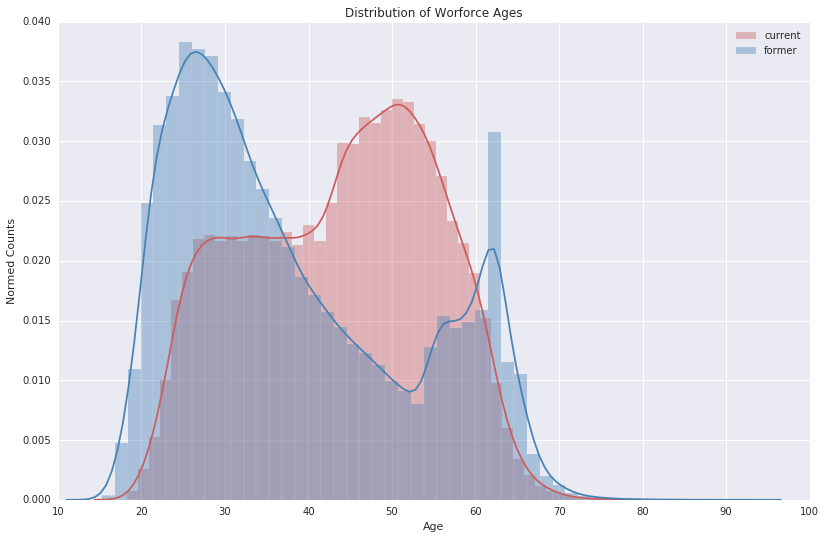

In [53]:
# look at these distributions
plt.figure(figsize=(12,8))
sns.distplot(empltbl2[empltbl2.status==0].Age_years,color='indianred',label='current')
sns.distplot(empltbl2[empltbl2.status==1].Age_years,color='steelblue',label='former')

#cur_empl.Age_years.hist(bins=80,color='indianred',label='current',alpha=0.8,normed=True)
#ret_empl.Age_years.hist(bins=80,color='steelblue',label='retired',alpha=0.5,normed=True)
plt.legend()
plt.xlabel('Age')
plt.ylabel('Normed Counts')
plt.title('Distribution of Worforce Ages')

In [54]:
neg_tenure_idx = ret_empl[ret_empl.TOT_MO_SERVICE_SFI < 0].index
ret_empl.ix[neg_tenure_idx][['TOT_MO_SERVICE_SFI','Tenure_months','TERMINATION_DT','HIRE_DT','LAST_HIRE_DT','BIRTHDATE']].head(30)

,TOT_MO_SERVICE_SFI,Tenure_months,TERMINATION_DT,HIRE_DT,LAST_HIRE_DT,BIRTHDATE
1397,-219,20.140044,1988-05-27,1986-09-22,2008-04-07,1964-01-31
2752,-3,2.628391,1988-08-19,1988-05-31,1988-05-31,1956-04-22
3267,-13,147.321300,1988-09-16,1976-06-07,1976-06-07,1958-08-16
20334,-251,3.351198,1993-01-15,1992-10-05,1992-10-05,1974-05-24
20353,-244,7.852317,1993-01-20,1992-05-26,1992-05-26,1960-11-19
22598,-237,2.661246,1993-08-13,1993-05-24,1993-05-24,1959-02-26
26363,-219,26.053923,1994-07-29,1992-05-27,1994-05-19,1972-06-26
27105,-2,27.039570,1994-08-19,1992-05-18,1994-05-16,1973-02-22
32283,-166,6.899526,1995-08-25,1995-01-27,1995-01-27,1963-01-24
34008,-44,278.970821,1995-12-01,1972-09-01,1972-09-01,1955-05-11


In [55]:
neg_tenure_idx = ret_empl[ret_empl.Tenure_months < 0].index
ret_empl.ix[neg_tenure_idx][['TOT_MO_SERVICE_SFI','Tenure_months','TERMINATION_DT','HIRE_DT','LAST_HIRE_DT']].tail(30)

,TOT_MO_SERVICE_SFI,Tenure_months,TERMINATION_DT,HIRE_DT,LAST_HIRE_DT
144694,-1,-0.032855,2000-04-16,2000-04-17,2000-04-17
144848,-1,-0.032855,2006-05-05,2006-05-06,2006-05-06
145396,-1,-0.032855,2008-05-13,2008-05-14,2008-05-14
145501,-1,-0.032855,2006-02-26,2006-02-27,2006-02-27
145729,-1,-0.032855,2001-09-03,2001-09-04,2001-09-04
146499,-1,-0.032855,2001-05-11,2001-05-12,2001-05-12
146500,-1,-0.032855,2001-05-11,2001-05-12,2001-05-12
146586,-1,-0.032855,2000-03-12,2000-03-13,2000-03-13
146587,-1,-0.032855,2000-03-12,2000-03-13,2000-03-13
147883,-1,-0.032855,2008-02-03,2008-02-04,2008-02-04


In [ ]:
ret_empl.ix[neg_tenure_idx]['KEY'].tail().values

# Cleaning up these dates
### remove the negative tenure cases

In [138]:
empltbl3 = empltbl2[empltbl2.Tenure_months>=0].copy()
len(empltbl3)

199346

In [139]:
# how many are younger than 16?
sum(empltbl3.Age_years < 16.01), sum(empltbl3.Age_years > 70)#, sum(cur_empl.Age_years < 16.01)

(7, 473)

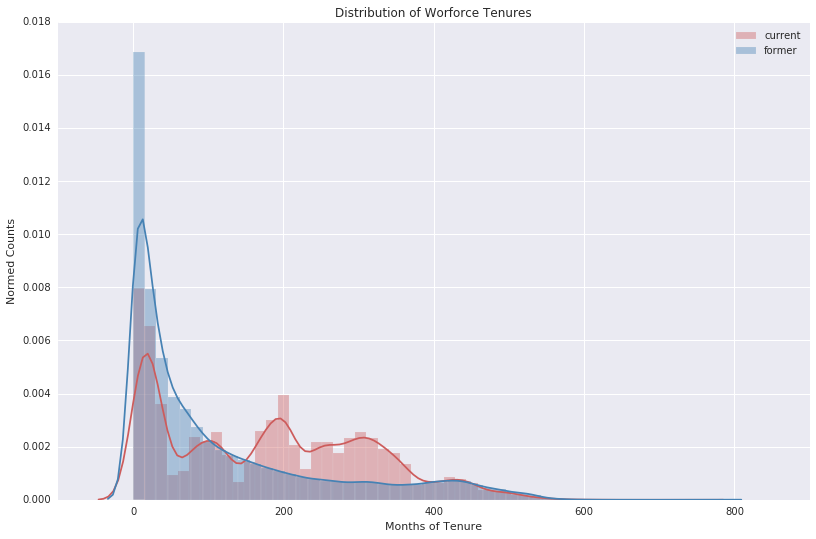

In [140]:
# look at these distributions
plt.figure(figsize=(12,8))
sns.distplot(empltbl3[empltbl3.status==0].Tenure_months,color='indianred',label='current')
sns.distplot(empltbl3[empltbl3.status==1].Tenure_months,color='steelblue',label='former')

#cur_empl.Age_years.hist(bins=80,color='indianred',label='current',alpha=0.8,normed=True)
#ret_empl.Age_years.hist(bins=80,color='steelblue',label='retired',alpha=0.5,normed=True)
plt.legend()

plt.xlabel('Months of Tenure')
plt.ylabel('Normed Counts')
plt.title('Distribution of Worforce Tenures')

In [141]:
# look at these distributions
#plt.figure(figsize=(12,8))
#empltbl3[empltbl3.status==0].Tenure_months.hist(bins=80,color='indianred',label='current',alpha=0.8,normed=True)
#empltbl3[empltbl3.status==1].Tenure_months.hist(bins=80,color='steelblue',label='former',alpha=0.5,normed=True)
#plt.legend()
#plt.xlabel('Months of Tenure')
#plt.ylabel('Normed Counts')
#plt.title('Distribution of Worforce Tenures')

In [142]:
## convert months of tenure to years of tenure
empltbl3['Tenure_years'] = empltbl3['Tenure_months']/12.0

In [143]:
empltbl3.Tenure_years.describe()

count    199346.000000
mean         11.387131
std          11.565520
min           0.000000
25%           1.659172
50%           6.926905
75%          18.636933
max          64.622819
Name: Tenure_years, dtype: float64

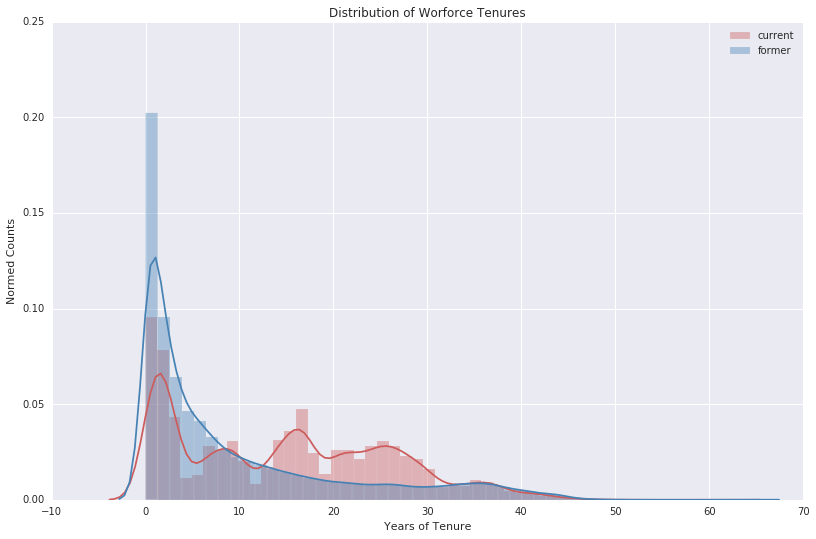

In [144]:
# look at these distributions
plt.figure(figsize=(12,8))
sns.distplot(empltbl3[empltbl3.status==0].Tenure_years,color='indianred',label='current')
sns.distplot(empltbl3[empltbl3.status==1].Tenure_years,color='steelblue',label='former')
#empltbl3[empltbl3.status==0].Tenure_years.hist(bins=60,range=[0,59],color='indianred',label='current',alpha=0.8,normed=True)
#empltbl3[empltbl3.status==1].Tenure_years.hist(bins=60,range=[0,59],color='steelblue',label='former',alpha=0.5,normed=True)
plt.legend()
plt.xlabel('Years of Tenure')
plt.ylabel('Normed Counts')
plt.title('Distribution of Worforce Tenures')

## look for duplicated KEYS (and remove)

In [145]:
duplicated_keys_list = list(empltbl3.KEY.value_counts()[empltbl3.KEY.value_counts() >1].index)
duplicated_keys_list

[]

In [146]:
empltbl3.status.value_counts()

1    129540
0     69806
Name: status, dtype: int64

## plot age distributions

In [147]:
empltbl3.Age_years.describe()

count    199346.000000
mean         40.197426
std          13.345862
min          15.263832
25%          28.591963
50%          38.199279
75%          51.426107
max          92.346865
Name: Age_years, dtype: float64

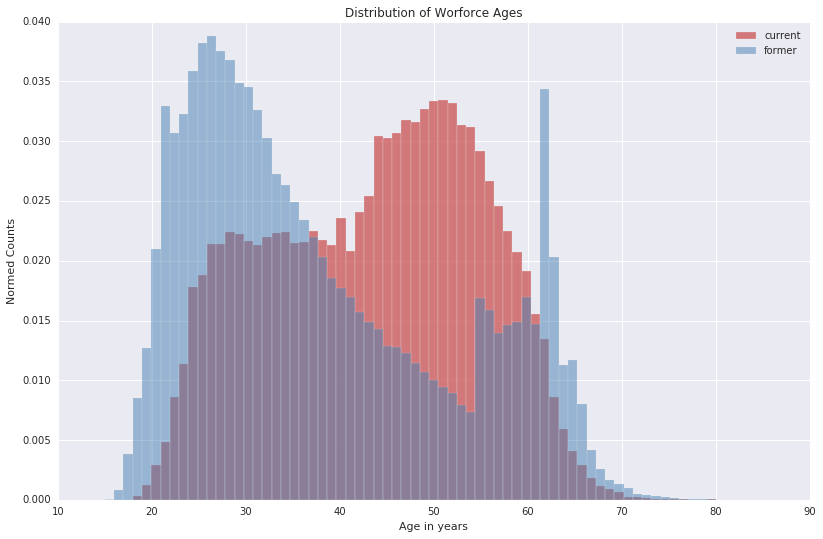

In [148]:
# look at these distributions
plt.figure(figsize=(12,8))
empltbl3[empltbl3.status==0].Age_years.hist(bins=70,range=[15,84],color='indianred',label='current',alpha=0.8,normed=True)
empltbl3[empltbl3.status==1].Age_years.hist(bins=70,range=[15,84],color='steelblue',label='former',alpha=0.5,normed=True)
plt.legend()
plt.xlabel('Age in years')
plt.ylabel('Normed Counts')
plt.title('Distribution of Worforce Ages')

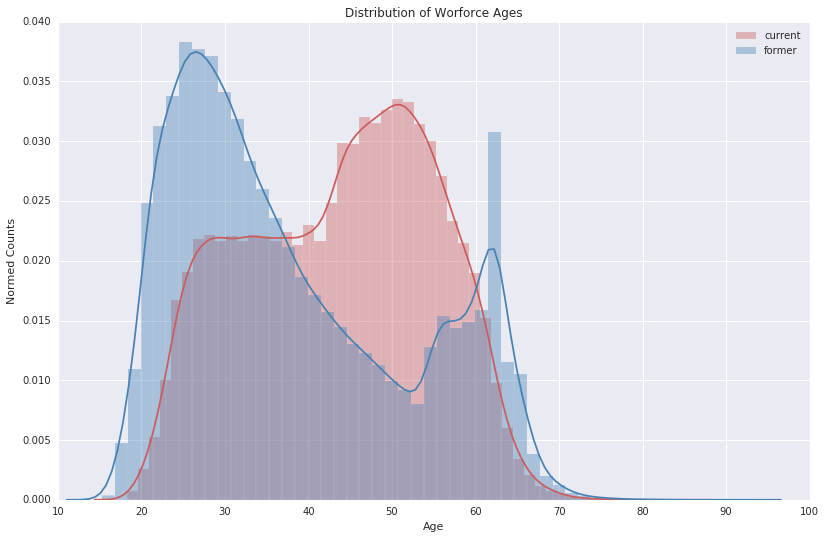

In [149]:
# look at these distributions
plt.figure(figsize=(12,8))
sns.distplot(empltbl3[empltbl3.status==0].Age_years,color='indianred',label='current')
sns.distplot(empltbl3[empltbl3.status==1].Age_years,color='steelblue',label='former')

#cur_empl.Age_years.hist(bins=80,color='indianred',label='current',alpha=0.8,normed=True)
#ret_empl.Age_years.hist(bins=80,color='steelblue',label='retired',alpha=0.5,normed=True)
plt.legend()
plt.xlabel('Age')
plt.ylabel('Normed Counts')
plt.title('Distribution of Worforce Ages')

### compare the type of separation

In [150]:
empltbl3.VOLINVOL.value_counts()

VOLUNTARY      89993
NOT            69806
INVOLUNTARY    38728
UNKNOWN          496
OTHER            323
Name: VOLINVOL, dtype: int64

In [151]:
empltbl3.KEY.nunique()

199346

In [152]:
## Drop the TOT_MO_SERVICE_SFI column --> it's values seem to be erroneous generally
# drop PER_ORG because it is singly valued
empltbl3.drop(['PER_ORG','TOT_MO_SERVICE_SFI'],axis=1,inplace=True)

### Import and join BENEFITS information

In [72]:
infilenames[6]

'/data/discovery/hrsepara/core/SR_BENEFIT.txt'

In [153]:
bene_df = pandas_read_hdfs(infilenames[6],dtype_dict={'KEY':np.str})
bene_df.shape

(86954, 4)

In [154]:
bene_df.replace({'Y': 1, 'N':0},inplace=True)
bene_df.head()

,KEY,HAVE_INS,HAVE_DEP,COUNT
0,782034519027003,1,0,0
1,606846618748664,1,1,1
2,932378015449447,1,1,2
3,892115452742258,1,0,0
4,149888337659598,1,1,1


In [155]:
# rename 'COUNT               ' 'DEP_COUNT'
bene_df = bene_df.rename(columns={'COUNT               ':'DEP_COUNT'})

In [156]:
bene_df.HAVE_INS.sum() == len(bene_df)

True

In [157]:
empl_bene = pd.merge(empltbl3,bene_df,on='KEY',how = 'left')

In [158]:
len(empl_bene),empl_bene.VOLINVOL.value_counts()

(199346, VOLUNTARY      89993
 NOT            69806
 INVOLUNTARY    38728
 UNKNOWN          496
 OTHER            323
 Name: VOLINVOL, dtype: int64)

In [159]:
empl_bene.index.nunique()

199346

### assign random numbers to the indices

In [160]:
import random
list_of_indices = list(range(empl_bene.KEY.nunique()))
print len(list_of_indices )
random.seed(883321)
#new_indices = [x for x in random.shuffle(list_of_indices)
random.shuffle(list_of_indices)#, len(list_of_indices))
empl_bene.index = list_of_indices # note that random.shuffle does this shuffling inplace
empl_bene.sort_index(inplace=True)
print empl_bene.index.nunique()
empl_bene.head()

199346
199346


,ACTRES1,ACTRES10,ACTRES2,ACTRES3,ACTRES4,ACTRES5,ACTRES6,ACTRES7,ACTRES8,ACTRES9,...,TERMINATION_DT,TOTAL_RPT_CNT,Tenure_months,Tenure_tdelta,VOLINVOL,status,Tenure_years,HAVE_INS,HAVE_DEP,DEP_COUNT
0,MERIT;REGULAR RETIREMENT,MERIT;COMPANY WIDE CONVERSION;REGIONAL CONVERS...,LOCATION/FLOOR CHANGE;MERIT;JOB CODE CHANGE;TR...,MISCELLANEOUS DATA CHANGE;MERIT;TRANSFER W/O J...,MERIT;TRANSFER W/O JOB NUMBER CHANGE,TRANSFER W/ JOB NUMBER CHANGE;MERIT;MISCELLANE...,MERIT,TRANSFER W/O JOB NUMBER CHANGE;MERIT,LOCATION/FLOOR CHANGE;MERIT;TRANSFER W/O JOB N...,REVIEW DATE CHANGE;MERIT;RATING SCALE CONVERSION,...,2009-05-31,6,484.248137,14739 days,VOLUNTARY,1,40.354011,NaN,NaN,NaN
1,MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2015-01-01,17,6.768106,206 days,NOT,0,0.564009,NaN,NaN,NaN
2,MERIT;ELIMINATION OF POSITION;COMPANY WIDE CON...,NaN,MERIT;TRANSFER W/O JOB NUMBER CHANGE,MERIT,MERIT,MERIT;TRANSFER W/O JOB NUMBER CHANGE,MERIT;ORGANIZATIONAL CHANGES;TRANSFER W/O JOB ...,MERIT;TRANSFER W/O JOB NUMBER CHANGE,EMPLOYEE NEW HIRE;MERIT;TRANSFER W/O JOB NUMBE...,NaN,...,1997-06-13,NaN,88.905316,2706 days,INVOLUNTARY,1,7.408776,NaN,NaN,NaN
3,EMPLOYEE NEW HIRE;MARRIAGE;LOCATION/FLOOR CHAN...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2000-09-23,12,3.154069,96 days,VOLUNTARY,1,0.262839,NaN,NaN,NaN
4,MISCELLANEOUS DATA CHANGE;SALARY ADJUSTMENT;TR...,NaN,MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA C...,MISCELLANEOUS DATA CHANGE;EMPLOYEE NEW HIRE,NaN,NaN,NaN,NaN,NaN,NaN,...,2015-01-01,14,24.706873,752 days,NOT,0,2.058906,1,0,0


## Encode some categorical variables that are complete
0. fill in benefit column, missing counts as 0
1. volinvol status  into sep_status
2. MAR_STA_SNAME_SFI into mar_status
3. create a 5code zipcode from POSTAL_SFI (missing flagged as XXXXX)

In [161]:
empl_bene[bene_df.columns] = empl_bene[bene_df.columns].fillna(0)
empl_bene['DEP_COUNT'].describe()

count    199346.000000
mean          0.578632
std           1.309877
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          50.000000
Name: DEP_COUNT, dtype: float64

In [162]:
#empl_ben
#encode the VOLINVOL column as ['INVOLUNTARY':2,'VOLUNTARY':1,'NOT':0,'
empl_bene['sep_status'] = empl_bene['VOLINVOL'].replace({'NOT':0,'VOLUNTARY':1,'INVOLUNTARY':2,'OTHER':3,'UNKNOWN':3})
print empl_bene.sep_status.value_counts()
empl_bene.drop('VOLINVOL',axis=1,inplace=True)

1    89993
0    69806
2    38728
3      819
Name: sep_status, dtype: int64


In [163]:
## deal with MAR_STA_SNAME_SFI
empl_bene['mar_status'] = empl_bene['MAR_STA_SNAME_SFI'].replace({'MARRIED':0,'SINGLE':1,'LEG SEPAR':2})
#, SINGLE, LEG SEPAR#{'NOT':0,'VOLUNTARY':1,'INVOLUNTARY':2,'OTHER':3,'UNKNOWN':3})
print empl_bene.mar_status.value_counts()
empl_bene.drop('MAR_STA_SNAME_SFI',axis=1,inplace=True)

0    108752
1     90323
2       271
Name: mar_status, dtype: int64


In [164]:
## try to deal with location via zipcode
empl_bene['zip5'] = empl_bene['POSTAL_SFI'].apply(lambda(x): truncate_postal_zip(x))
empl_bene.drop('POSTAL_SFI',axis=1,inplace=True)
empl_bene['zip5'].unique()

array(['34746', '85281', '19508', ..., '95322', '75688', '23438'], dtype=object)

## remove Rows (i.e. employees ) corresponding to certain characteristics
1. keep only those that are known (vol,invol, not) per discussion on April 22, 2015
2. remove grades starting with 'L' and 'AT'
    * As we discussed, I'm already excluding seasonal employees, interns, and agency interns. 
    * Let’s also exclude the L-Level executive employees are in the LDSH job group with job grades L1 to L10 (i.e., all job grades starting with “L”). 
    * Let’s also exclude Air Transportation as we don’t foresee applying the model to them either. Their job group is AIRT with job grades AT1 to AT8 (i.e., all job grades starting with “AT”).
3. take a time slice --> only after 01-01-2002
 

In [165]:
# remove sep_status over 1
empl_bene = empl_bene[empl_bene.sep_status<=2]
print np.shape(empl_bene)

(198527, 186)


In [166]:
# remove AT* and L* grades
list_of_grades = empl_bene.GRADE.unique()
print len(list_of_grades)
grades_to_drop = [x for x in map(str,list_of_grades) if (x.startswith('L') or x.startswith('AT'))]
print len(grades_to_drop)
grades_to_drop.remove('LS2')
grades_to_drop.remove('LS1')
grades_to_drop.remove('LS3')
grades_to_drop.remove('LM1')
grades_to_drop.remove('LM2')
grades_to_drop.remove('LP1')
print len(grades_to_drop),grades_to_drop

164
24
18 ['L10', 'L6', 'L4', 'L9', 'L7', 'AT8', 'L5', 'L8', 'L3', 'L2', 'AT5', 'AT4', 'AT3', 'L1', 'AT7', 'AT6', 'AT2', 'AT1']


In [167]:
print "removing these {0} grades removes {1} employees".format(len(grades_to_drop),len(empl_bene[empl_bene.GRADE.isin(grades_to_drop)]))
empl=empl_bene[~empl_bene.GRADE.isin(grades_to_drop)].copy()
print np.shape(empl)

removing these 18 grades removes 579 employees
(197948, 186)


## Create a column for Retired based upon ACTRES1

In [168]:
empl.ACTRES1.fillna('MISSING',inplace=True)

In [169]:
## define the possible retire_codes first
## identify unique actres1 listing
# look at the list of ACTRES1 for  ReTIREMENT
uniq_action_reasons_1 = empl.ACTRES1.unique()
print len(uniq_action_reasons_1)
temp_list = [x.split(';') for x in uniq_action_reasons_1]

act_reason_1_list = list(chain.from_iterable(temp_list))
print len(act_reason_1_list)
# identify those that are Retirement related

possible_retire_codes = [x for x in list(set(act_reason_1_list)) if ('RET' in x and  'RETURN' not in x) ]
# If one wants to flag DISABILITY add the next line
#possible_retire_codes.append('DISABILITY')
print len(possible_retire_codes)
possible_retire_codes

25380
142694
22


['RET W/ VOLUNTARY SEVERANCE',
 'WINDOW 1 - RET WITH INVOL SEV',
 'EARLY RETIREMENT',
 'WINDOW 4 - RET WITH INVOL SEV',
 'WINDOW 4 - EARLY RET INCENTIVE',
 'RET W/ INVOLUNTARY SEVERANCE',
 'PART-TIME RETIREE',
 'PART-TIME RETIREE - NO GI',
 'WINDOW 2 - EARLY RET INCENTIVE',
 'WINDOW 3 - RET WITH INVOL SEV',
 'WINDOW 6 - RET WITH INVOL SEV',
 'WINDOW 1 - EARLY RET INCENTIVE',
 'WINDOW 0 - EARLY RET INCENTIVE',
 'WINDOW 6 - EARLY RET INCENTIVE',
 'RETIREE',
 'WINDOW 0 - RET WITH INVOL SEV',
 'WINDOW 5 - RET WITH INVOL SEV',
 'NORMAL RETIREMENT',
 'WINDOW 3 - EARLY RET INCENTIVE',
 'REGULAR RETIREMENT',
 'WINDOW 2 - RET WITH INVOL SEV',
 'WINDOW 5 - EARLY RET INCENTIVE']

In [170]:
# function to generate flag
def identify_retired(x,ret_codes =possible_retire_codes):
    matched = [a for a in x.split(';') if a in ret_codes]
    if len(matched):
        return 1
    else:
        return 0

In [171]:
empl['retired'] = empl.ACTRES1.apply(lambda x: identify_retired(x))

### try to check these retired instances

#### There is  one case where the person is 'retired' but has status of 0 is wrong -- I'm removing this row

In [172]:
empl[(empl.status == 0)& (empl.retired == 1)]

,ACTRES1,ACTRES10,ACTRES2,ACTRES3,ACTRES4,ACTRES5,ACTRES6,ACTRES7,ACTRES8,ACTRES9,...,Tenure_tdelta,status,Tenure_years,HAVE_INS,HAVE_DEP,DEP_COUNT,sep_status,mar_status,zip5,retired
197913,TRANSFER W/O JOB NUMBER CHANGE;RETIREE,MISCELLANEOUS DATA CHANGE;MERIT,INVOL SEVERANCE AFTER 9/1/2005,SALARY PLAN CHANGE;INCENTIVE;MERIT;TRANSFER W/...,TRANSFER W/O JOB NUMBER CHANGE;SP/DEP LOSES EL...,SP/DEP GAINS ELIGIBILITY;MISCELLANEOUS DATA CH...,MERIT,MERIT,MERIT;MISCELLANEOUS DATA CHANGE,SALARY PLAN CHANGE;SALARY PLAN CHANGE;MERIT,...,11910 days,0,32.608472,0,0,0,0,0,49301,1


In [173]:
empl[(empl.retired==1) & (empl.status==0)][['BIRTHDATE','HIRE_DT','TERMINATION_DT','LAST_HIRE_DT','KEY']]

,BIRTHDATE,HIRE_DT,TERMINATION_DT,LAST_HIRE_DT,KEY
197913,1958-06-26,1982-05-24,2015-01-01,2014-10-13,185980322857378


In [174]:
empl.retired.value_counts()

0    175233
1     22715
Name: retired, dtype: int64

In [175]:
wrong_status_key = empl[(empl.status == 0)& (empl.retired == 1)].KEY.values
print wrong_status_key


['185980322857378']


In [176]:
empl[empl.KEY==wrong_status_key[0]][['retired','status']]

,retired,status
197913,1,0


In [177]:
empl = empl[empl.KEY!=wrong_status_key[0]] #drop(empl.index[wrong_status_idx]).copy()#ix[:wrong_status_idx].tail()
len(empl)

197947

In [183]:
empl.retired.value_counts()

0    175233
1     22714
Name: retired, dtype: int64

### Create a column for terminated (i.e separated but not Retired)
* requires that status == 1 but retired == 0

In [185]:
## create a column for terminated (i.e. separated but NOT retired)
empl['terminated']= 0
my_rows = empl[(empl.status==1) & (empl.retired==0)].index
print "Out of {0} rows, {1} are separated and not retired.".format(len(empl),len(my_rows))
#sum(empl_df['terminated']))#, len(my_rows)
empl.loc[my_rows,'terminated']=1
print sum(empl.terminated)

Out of 197947 rows, 105758 are separated and not retired.
105758


In [188]:
pd.crosstab(empl.status, empl.retired)

retired,0,1
status,,
0,69475,0
1,105758,22714


In [189]:
## eliminate if the termination date is before 2002 (stale data)
date0 = '2002-01-01'
em2002 = empl.ix[empl.TERMINATION_DT>=date0].copy()
print date0, len(em2002)
print "--------- STATUS "
print em2002.status.value_counts()
print "--------- TERMINATED"
print em2002.terminated.value_counts()
print "--------- RETIRED"
print em2002.retired.value_counts()
print np.shape(em2002)

2002-01-01 134196
--------- STATUS 
0    69475
1    64721
Name: status, dtype: int64
--------- TERMINATED
0    84345
1    49851
Name: terminated, dtype: int64
--------- RETIRED
0    119326
1     14870
Name: retired, dtype: int64
(134196, 188)


In [190]:
#empl[empl.retired==1][['Age_years','Tenure_years']].describe()
em2002[em2002.retired==1][['Age_years','Tenure_years']].describe()

,Age_years,Tenure_years
count,14870.000000,14870.000000
mean,60.668359,27.214920
std,3.626327,11.153948
min,54.999076,0.052020
25%,57.728769,17.528765
50%,60.849983,28.757606
75%,62.705600,36.575700
max,82.345291,59.650780


In [192]:
### specifically deal with those who were under 50empl[(empl.retired==1)&(empl.Age_years<50.0)]
em2002[(em2002.retired==1)&(em2002.Age_years<50.0)][['TERMINATION_DT','Age_years','BIRTHDATE','HIRE_DT','Tenure_years','ACTRES1']]

,TERMINATION_DT,Age_years,BIRTHDATE,HIRE_DT,Tenure_years,ACTRES1


In [194]:
print len(em2002[(em2002.retired==1)&(em2002.Tenure_years<5.0)][['TERMINATION_DT','Age_years','BIRTHDATE','HIRE_DT','Tenure_years','ACTRES1']])

56


In [321]:
sum(em2002['HIRE_DT']!=em2002['SERVICE_DT']), len(em2002)

(17187, 134196)

In [317]:
em2002[(em2002.retired==1)&(em2002.Tenure_years<5.0)][['TERMINATION_DT','Age_years','BIRTHDATE','HIRE_DT',
                                                       'Tenure_years','SERVICE_DT']]#ACTRES1,

,TERMINATION_DT,Age_years,BIRTHDATE,HIRE_DT,Tenure_years,SERVICE_DT
1448,2011-06-30,66.216281,1945-04-12,2006-08-28,4.837882,2006-08-28
1533,2014-11-30,67.223831,1947-09-10,2013-08-05,1.319671,2013-08-05
6167,2003-06-30,66.120454,1937-05-17,1999-05-03,4.158881,1999-05-03
11852,2012-10-31,82.290533,1930-07-18,2008-03-24,4.605160,2008-03-24
16464,2013-11-30,70.476464,1943-06-10,2010-01-04,3.904255,2010-01-04
18463,2002-12-31,66.227233,1936-10-09,1998-06-01,4.583256,1998-06-01
20426,2010-10-31,66.166999,1944-08-31,2007-02-26,3.677009,2007-02-26
21698,2002-06-30,66.859689,1935-08-21,1998-08-31,3.830332,1998-08-31
22874,2009-02-28,75.985133,1933-03-06,2006-07-31,2.581846,2006-07-31
35962,2012-09-30,65.832974,1946-12-01,2007-12-17,4.788599,2007-12-17


In [201]:
em2002[(em2002.retired==1)&(em2002.Tenure_years<5.0)][['KEY','ACTRES1','HIRE_DT','TERMINATION_DT','Age_years','Tenure_years']].to_csv('strange_retirement.csv',index=False)

In [202]:
%pwd

u'/home/kesj/work/hrsepara/eda'

In [197]:
em2002.shape

(134196, 188)

In [199]:
## save this file.
em2002.to_csv('after2001_v6.csv',index=False)

### Drop these strange retirement cases for now

In [226]:
retired_keys_to_drop = em2002[(em2002.retired==1)&(em2002.Tenure_years<5.0)].KEY.tolist()
print len(retired_keys_to_drop)
#em2 = em2002[~em2002.KEY.isin(retired_keys_to_drop)].copy()
#print len(em2)
## 2nd rule: if age is >=65 and tenure>=1 can retire:
real_retired_keys_to_drop = em2002[em2002.KEY.isin(retired_keys_to_drop)][(em2002.Tenure_years<1.0)|(em2002.Age_years<65.0)].KEY.tolist()
print len(real_retired_keys_to_drop)

56
7


In [227]:
em2 = em2002[~em2002.KEY.isin(real_retired_keys_to_drop)].copy()
#em2 = em2002[~em2002.KEY.isin(retired_keys_to_drop)].copy()
print em2.shape

(134189, 188)


In [228]:
## save this file.
em2.to_csv('after2001_v7.csv',index=False)

# Begin to step through columns using BEAR
1. list all the columns
2. identify columns that I don't want to include in the analysis
3. Identify columns that require further refinement
    * missing values
    * categorical
    * survival function
4. create test-train split (hold out eval set)

In [211]:
repodir = '/home/kesj/lib/repo/'
os.chdir(repodir)
import bear.bear as br
os.chdir(stgdir1local)

/opt/anaconda/2.3.0/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/opt/anaconda/2.3.0/lib/python2.7/site-packages/sklearn/qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


# Tweak some of the columns
1. convert tenure_months into tenure Years  and drop the tenure_months columns. Tenure in years is just easier to think about.
2. create timestamps for columns that are timestamps 
3. create a value for the age at hire (hire_age)

In [229]:
## create timestamps for columns that are timestamps
em2[['hire_tstmp','term_tstmp','birth_tstmp']] = em2[['HIRE_DT','TERMINATION_DT','BIRTHDATE']].apply(lambda x:pd.to_datetime(x))
## add a column for age at hire date
hire_age_tdelta = em2['hire_tstmp']-em2['birth_tstmp']
# convert to days, months, or years
em2['hire_age'] = hire_age_tdelta/np.timedelta64(1,'Y')
em2.drop('Tenure_months',axis=1,inplace=True)
em2.shape

(134189, 191)

In [230]:
all_cols = em2.columns.tolist()
print len(all_cols)

191


In [231]:
columns_with_missing1 = br.get_columns_with_nulls(em2,rows_to_scan='all')
print len(columns_with_missing1)

77


# Deal with missing values

In [219]:
for colname in columns_with_missing1:
    print colname, em2[colname].nunique(),sum(em2[colname].isnull())

ACTRES10 11266 64277
ACTRES2 15913 13732
ACTRES3 16233 28543
ACTRES4 15586 38522
ACTRES5 12691 44254
ACTRES6 10468 48245
ACTRES7 11765 51984
ACTRES8 10034 56745
ACTRES9 10458 60331
ADDRCNT1 5 20
ADDRCNT10 11 20
ADDRCNT3 9 20
ADDRCNT5 9 20
ADDRESS1 128070 21
ADDRESS2 6342 123486
BOX1 3 25320
BOX10 3 70214
BOX2 3 30624
BOX3 3 40065
BOX4 3 46060
BOX5 3 50368
BOX6 3 54413
BOX7 3 59366
BOX8 3 62945
BOX9 3 66766
DIRECT_RPT_CNT 172 1964
EXTFUNC_CNT 6510 58
FUNC_CNT 7784 5
GRADE 122 1
JOB_FAMILY 1447 4481
JOB_FUNCTION 18 4511
LOC_CITY 3607 3
LOC_STATE 51 3
LOC_TYPE_DESCR_SFI 30 1
MAR_STATUS_DT 4901 70354
MERIT1 74154 15043
MERIT10 45035 15043
MERIT2 74831 15043
MERIT3 71168 15043
MERIT4 66953 15043
MERIT5 63701 15043
MERIT6 60788 15043
MERIT7 57882 15043
MERIT8 52986 15043
MERIT9 49076 15043
PERF1 78501 15043
PERF10 42037 15043
PERF2 75319 15043
PERF3 68781 15043
PERF4 63026 15043
PERF5 57949 15043
PERF6 53680 15043
PERF7 50436 15043
PERF8 46853 15043
PERF9 44575 15043
RATE1 52 25280
RATE10 54

In [235]:
em2.BOX1.nunique(),em2.RATE1.nunique()

(3, 52)

### so 77 of 191 columns have missing values still. Work on Correcting these.
#### some logic:
* if it is a count (like ADDRCNT*) set missing to -1
* if it is an ACTION REASON, set to 'MISSING' (like ACTRES1)
* if it is a performance assessment (like BOX*) set to 0; L will become 1, S will become 2, H will become 3.
* if it is a float (like MERIT*, PERF*, ...) try to reassign by imputation.
* assign a value:
    * if 'HAVE_INS' or 'HAVE_DEP' assign 0, 0 to values

In [221]:
chg_to_zero_cols = ['BOX1','BOX2','BOX3','BOX4','BOX5','BOX6','BOX7','BOX8','BOX9','BOX10']
#['HAVE_INS','HAVE_DEP','DEP_COUNT','BOX1','BOX2','BOX3','BOX4','BOX5','BOX6','BOX7','BOX8','BOX9','BOX10']
chg_to_neg_one_cols = ['ADDRCNT1','ADDRCNT3','ADDRCNT5','ADDRCNT10',
                           'DIRECT_RPT_CNT', 'DIVISION_CODE_SFI','EXTFUNC_CNT','FUNC_CNT','TOTAL_RPT_CNT']
                          
chg_to_MISSING_cols = ['ACTRES1','ACTRES2','ACTRES3','ACTRES4','ACTRES5','ACTRES6','ACTRES7','ACTRES8','ACTRES9','ACTRES10',
                      'ADDRESS1','JOB_FAMILY','LOC_CITY','LOC_TYPE_DESCR_SFI','SKEY',
                      'RATE1', 'RATE10', 'RATE2', 'RATE3', 'RATE4', 'RATE5', 'RATE6', 'RATE7', 'RATE8', 'RATE9',]
#chg_to_MISSING =['ACTRES1','ACTRES2','ADDRESS1','JOB_FAMILY', 'LOC_CITY','LOC_TYPE_DESCR_SFI']#'POSTAL_SFI',
chg_to_00000 = ['EXT_FUNC_ID_SFI','FUNC_ID_SFI']#,'zip5']
chg_to_XXX = ['GRADE','JOB_FUNCTION']
chg_to_XX = ['LOC_STATE']
col_to_drop = ['STATE','ADDRESS2','MAR_STATUS_DT'] # drop 'STATE'; some strange values; 'address2 x_missing too high'

In [222]:
# lump these together
correcting_col_list = [chg_to_zero_cols,chg_to_neg_one_cols,chg_to_MISSING_cols,chg_to_00000,chg_to_XXX,chg_to_XX,col_to_drop]
print sum([len(x) for x in correcting_col_list])

52


### apply the logic for the above columns

In [236]:
replace_code = [0,-1,'MISSING','00000','XXX','XX','drop'] #poor man's dictionary

In [237]:
empl = em2.copy()
for id,col_list in enumerate(correcting_col_list):
    print id, len(col_list), replace_code[id]
    
    if replace_code[id] == 'drop':
        empl.drop(col_list,axis=1,inplace=True)
        #print col_list
    else:
        empl[col_list]=empl[col_list].fillna(replace_code[id]).copy()

0 10 0
1 9 -1
2 25 MISSING
3 2 00000
4 2 XXX
5 1 XX
6 3 drop


In [238]:
empl.shape

(134189, 188)

## begin to Standardize some of these other columns
1. BOX columns: missing -> 0, L -> 1, S -> 2, H -> 3
2. RATE columns: use dictionary; missing -> 0, 


In [239]:
### For BOX replace S with 2, H with 3, L with 1
box_col_list = [x for x in empl.columns if x.startswith('BOX')]
print len(box_col_list)
empl[box_col_list] = empl[box_col_list].replace({'H':3,'S':2,'L':1}).copy()
empl[box_col_list].head()

10


,BOX1,BOX10,BOX2,BOX3,BOX4,BOX5,BOX6,BOX7,BOX8,BOX9
0,2,2,2,2,2,2,2,2,3,2
1,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0
6,2,2,2,2,2,2,2,2,2,2
8,2,0,0,0,0,0,0,0,0,0


In [240]:
empl.BOX2.value_counts()

2    78394
0    30631
3    19896
1     5268
Name: BOX2, dtype: int64

## Simpler conversion of RATE* to 3 levels: Low, Solid or High
dictionary below from Ron Davis

In [241]:
# dictonary of ratings
ratings_dict = {}
high_ratings = ['R3C3','R3C2','L3EXC','L3-EXC','OTSD','L3PRO','L3-PRO',
                'EXCELS','SUPR','EXC/SUS','EXC/IMP','PEXE','ME - MEETS']
low_ratings = ['IMPR','L1INC','L1DEV','L1PRO','NTAC','R1C2','R1C3','INC/DEC',
               'INC/SUS','INC/IMP','INCNSSTE','L1EXC','UNAC','R1C1','L2-INC','L2INC',
               'L1-EXC','L1-PRO','BEXP','L1-DEV','L1-INC','DNM - DOES','R3C1','R2C1']
solid_ratings = ['R2C3','R2C2','L2EXC','L2PRO','EXPE','/EX/','COMM','AOBJ','EXC/DEC',
                 'PRO/IMP','PRO/SUS','PRO/DEC','SM - SUCCE','MS - MEETS','L2DEV','L3INC',
                 'L3DEV','L2-DEV','L3-INC','ACPT','L3-DEV','L2-EXC','L2-PRO']

# initialize
for rating in high_ratings:
    ratings_dict[rating] = 3
for rating in low_ratings:
    ratings_dict[rating]=1
for rating in solid_ratings:
    ratings_dict[rating]=2

# function for assigning
def assign_simple_rating(x,my_dict = ratings_dict):
    try:
        rval = my_dict[x.strip()]
    except KeyError:
        rval = 0
    return rval


In [242]:
### For Rate replace solid with 2, High with 3, Low with 1
rate_col_list = [x for x in empl.columns if x.startswith('RATE')]
print len(rate_col_list)
empl[rate_col_list] = empl[rate_col_list].applymap(lambda x: assign_simple_rating(x))
#empl[rate_col_list] = empl[rate_col_list].map(lambda(x): assign_simple_rating(x)).copy()
empl[rate_col_list].head()

10


,RATE1,RATE10,RATE2,RATE3,RATE4,RATE5,RATE6,RATE7,RATE8,RATE9
0,2,2,2,2,2,2,2,2,3,2
1,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0
6,2,2,2,2,2,2,2,2,2,2
8,2,0,0,0,0,0,0,0,0,0


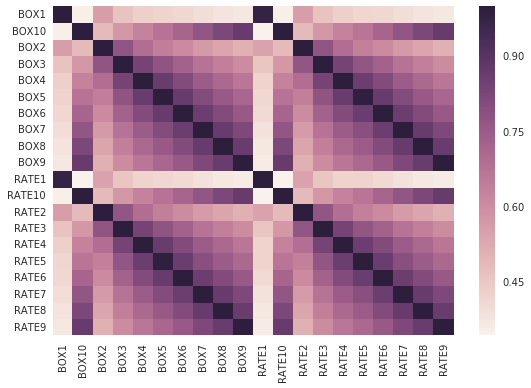

In [243]:

box_rate_list = []
box_rate_list +=box_col_list
box_rate_list += rate_col_list
sns.heatmap(empl[box_rate_list].corr())

#### Observation: the RATES are more closely correlated that the BOXES -- not that it matters if I only keep the recent values ('1')

In [245]:
print len(empl[(empl['BOX1']==0)&(empl['RATE1']!=0)])

empl[(empl['BOX1']==0)&(empl['RATE1']!=0)][['BOX1','RATE1','Tenure_years','TERMINATION_DT']]

4


,BOX1,RATE1,Tenure_years,TERMINATION_DT
53528,0,3,45.287720,2005-02-28
56313,0,3,44.469086,2005-01-31
75864,0,3,8.022068,2002-11-01
180009,0,3,6.806437,2006-02-28


In [249]:
print len(empl[(empl['BOX1']!=0)&(empl['RATE1']==0)])

#empl[(empl['BOX1']!=0)&(empl['RATE1']==0)][['BOX1','RATE1','Tenure_years','TERMINATION_DT']]

1194


### re-examine wheich ones are missing

In [250]:
columns_with_missing2 = br.get_columns_with_nulls(empl,rows_to_scan='all')
print len(columns_with_missing2)

29


In [251]:
[colname for colname in columns_with_missing2]

['MERIT1',
 'MERIT10',
 'MERIT2',
 'MERIT3',
 'MERIT4',
 'MERIT5',
 'MERIT6',
 'MERIT7',
 'MERIT8',
 'MERIT9',
 'PERF1',
 'PERF10',
 'PERF2',
 'PERF3',
 'PERF4',
 'PERF5',
 'PERF6',
 'PERF7',
 'PERF8',
 'PERF9',
 'SAL10',
 'SAL2',
 'SAL3',
 'SAL4',
 'SAL5',
 'SAL6',
 'SAL7',
 'SAL8',
 'SAL9']

## Proces the categorical columns now

In [252]:
numeric_cols = br.get_numeric(empl)
categorical_cols = br.get_categorical(empl)
print len(numeric_cols)+len(categorical_cols), len(numeric_cols),len(categorical_cols)

178 129 49


In [255]:
sdf = br.summarize_dataframe(empl[categorical_cols])
sdf.sort_values(by='arity')

,feature,datatype,nmissing,arity,accepted values,x_missing
19,FULLPART1,object,0,2,"[N, Y]",0
37,PARTFULL1,object,0,2,"[N, Y]",0
40,PARTFULL5,object,0,2,"[N, Y]",0
41,RELOCATE_ALL_SFI,object,0,2,"[N, Y]",0
27,INTERN,object,0,2,"[N, Y]",0
26,HUBIND,object,0,2,"[N, Y]",0
47,SUPV_DIFF_LOC,object,0,2,"[Y, N]",0
22,FULLPART5,object,0,2,"[N, Y]",0
21,FULLPART3,object,0,2,"[N, Y]",0
20,FULLPART10,object,0,2,"[N, Y]",0


### List some HIGH arity columns to drop:

In [271]:
cat_cols_to_drop = [colname for colname in all_cols if colname.startswith('ACTRES')]
cat_cols_to_drop.append('ADDRESS1')
cat_cols_to_drop.append('SKEY')
cat_cols_to_drop.append('zip5')
cat_cols_to_drop.append('LEGACY_DEPT_SFI')
cat_cols_to_drop.append('LOCATION')
cat_cols_to_drop.append('LOC_CITY')
for col in col_to_drop:
    cat_cols_to_drop.append(col)

In [272]:
print len(cat_cols_to_drop), len(all_cols), len(rate_col_list)

19 191 10


In [273]:
col_to_model1 = [col for col in all_cols]
for aname in cat_cols_to_drop:
    col_to_model1.remove(aname)
for aname in rate_col_list:
    col_to_model1.remove(aname)

print len(col_to_model1)

162


### Keep just the most recent values so as to not bias it away from those who have been there longer. 
(too many missing instances)

In [286]:
missing_cols_2 = br.get_columns_with_nulls(empl[col_to_model1],'all')
len(missing_cols_2)

2

In [279]:
#br.get_columns_with_nulls(empl[col_to_model1],'all')
historical_cols = [colname for colname in missing_cols_2 if not colname.endswith('1')]
len(historical_cols)

27

In [285]:

        
for hname in historical_cols:
    col_to_model1.remove(hname)

print len(col_to_model1)

ValueError: list.remove(x): x not in list

In [287]:
for boxcol in box_col_list:
    if not boxcol.endswith('1'):
        col_to_model1.remove(boxcol)
        
print len(col_to_model1)

126


In [288]:
empl[col_to_model1].to_csv('after2001_v8.csv',index=False)

## Process the categorical ones left
1. binary <--> use scikitlearn to label encode binary features: 
    * N--> 0, Y --> 1
    * M--> 1, F --> 0
    * A-->0, H--> 1
2. special case for FLSA_STATUS which has arity=3
3. ..

In [301]:
[c for c in col_to_model1 if c.startswith('ACT')]

[]

In [257]:
binary_cols = sdf[sdf.arity == 2].feature.values.tolist()
print binary_cols

['COMP_FREQUENCY', 'FULLPART1', 'FULLPART10', 'FULLPART3', 'FULLPART5', 'HUBIND', 'INTERN', 'PARTFULL1', 'PARTFULL10', 'PARTFULL3', 'PARTFULL5', 'RELOCATE_ALL_SFI', 'REMOTE', 'REMOTE_SUPV', 'SEX', 'SUPV_DIFF_LOC']


In [294]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()


In [305]:
empl2 = empl[col_to_model1].copy()
empl2.shape

(134189, 126)

In [306]:
for col in binary_cols:
    print col, len(empl2[col].unique()), empl2[col].unique()
    empl2[col] = label_encoder.fit_transform(empl2[col]) # use sklearn.preprocesing.LabelEncoder()

COMP_FREQUENCY 2 ['A' 'H']
FULLPART1 2 ['N' 'Y']
FULLPART10 2 ['N' 'Y']
FULLPART3 2 ['N' 'Y']
FULLPART5 2 ['N' 'Y']
HUBIND 2 ['N' 'Y']
INTERN 2 ['N' 'Y']
PARTFULL1 2 ['N' 'Y']
PARTFULL10 2 ['N' 'Y']
PARTFULL3 2 ['N' 'Y']
PARTFULL5 2 ['N' 'Y']
RELOCATE_ALL_SFI 2 ['N' 'Y']
REMOTE 2 ['N' 'Y']
REMOTE_SUPV 2 ['N' 'Y']
SEX 2 ['F' 'M']
SUPV_DIFF_LOC 2 ['Y' 'N']


### 2. Use this mapping for FLSA N --> 0 , X -->-1 , Z -->1

In [307]:
empl2['FLSA_STATUS'] = empl['FLSA_STATUS'].replace({'N':0,'Z':1,'X':-1}).copy()

In [308]:
empl2.FLSA_STATUS.value_counts()

 0    99460
 1    32789
-1     1940
Name: FLSA_STATUS, dtype: int64

In [310]:
br.get_columns_with_nulls(empl2)

['MERIT1', 'PERF1']

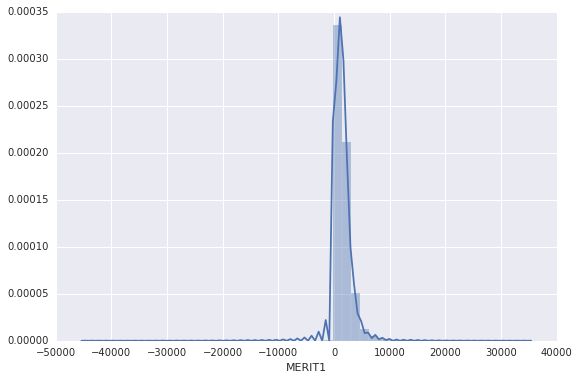

In [315]:
sns.distplot(empl2[empl2.MERIT1.notnull()].MERIT1)
#sns.distplot(empl2.PERF1)

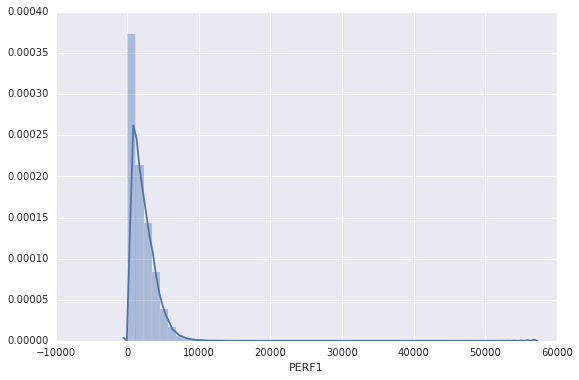

In [316]:
sns.distplot(empl2[empl2.PERF1.notnull()].PERF1)
#sns.distplot(empl2.PERF1)

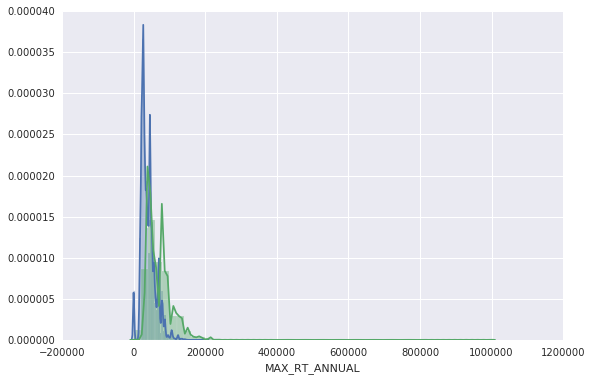

In [312]:
sns.distplot(empl2.MIN_RT_ANNUAL)
sns.distplot(empl2.MAX_RT_ANNUAL)

In [292]:
empl['EEO1CODE'].value_counts()

5    59008
2    55152
1    11622
4     5089
3     2446
7      482
6      383
N        3
L        3
8        1
Name: EEO1CODE, dtype: int64

In [ ]:
possible_class_targets = ['status','retired','terminated','sep_status']
possible_time_targets = ['Age_years','Tenure_years']
prep_dates = ['BIRTHDATE','HIRE_DT','TERMINATION_DT','']

###check on various  encoded variables
* arity = 3,Fine
* arity = 4, for 'SHIFT' map 'N' --> 0 and make FULL_PART_TIME categorical
* arity = 5 -- make EMPL_TYPE to categorical
* arity = 6, fine
* arity = 7, make COMPANY categorical
* arity = 8,9,10, fine
* arity = 11: EEO1CODE to categorical
* arity = 12: EMPL_CLASS to categorical
* arity = 19: JOB_FUNCTION to categorical

In [ ]:
em2[]

In [233]:
mos_cols = [x for x in em2002.columns if x.endswith('MOS')]
print len(mos_cols), mos_cols
#tstmp_cols = [x for x in em2002.columns if x.endswith('tstmp')]
#print len(tstmp_cols), tstmp_cols
date_cols = [x for x in em2002.columns if x.endswith('DT')]
date_cols.append('BIRTHDATE')
date_cols.append('Tenure_tdelta')
date_cols.append('Age_tdelta')
print len(date_cols), date_cols
useful_time_cols = []
useful_time_cols.append('Tenure_years')
useful_time_cols.append('Age_years')
useful_time_cols.append('hire_age')
print len(useful_time_cols), useful_time_cols

7 ['CUR_DEPT_MOS', 'CUR_EFUNC_MOS', 'CUR_FUNC_MOS', 'CUR_GRADE_MOS', 'CUR_JOB_MOS', 'CUR_LOC_MOS', 'TELE_MOS']
8 ['HIRE_DT', 'LAST_HIRE_DT', 'MAR_STATUS_DT', 'SERVICE_DT', 'TERMINATION_DT', 'BIRTHDATE', 'Tenure_tdelta', 'Age_tdelta']
3 ['Tenure_years', 'Age_years', 'hire_age']


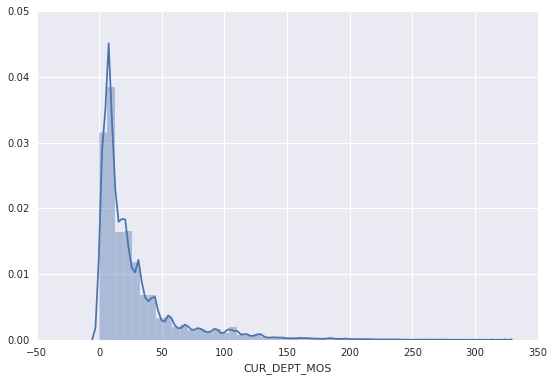

In [234]:
sns.distplot(em2.CUR_DEPT_MOS)

In [ ]:
## define some useful upload columns:
input_columns = ['KEY','HIRE_DT','BIRTHDATE','TERMINATION_DT']

In [ ]:
#bene_df.columns

In [ ]:
#
time_checking_cols = [a for a in date_columns]
time_checking_cols.append('Tenure_months')
time_checking_cols.append('Age_years')
time_checking_cols.append('CUR_LOC_MOS')

In [ ]:
#empl_bene[empl_bene.ACTRES1.isnull()][['LOC_STATE','TERMINATION_DT','HIRE_DT','status','COMPANY','KEY']]

In [ ]:
sdf = summarize_dataframe2(empl_bene)
sdf.sort('x_missing')

In [ ]:
set_missing_cols_yet_to_fix = set(columns_with_missing_values)-set(chain.from_iterable(correcting_col_list))
print len(set_missing_cols_yet_to_fix)

In [ ]:
replace_float_cols = ['MERIT1', 'MERIT10', 'MERIT2', 'MERIT3', 'MERIT4', 'MERIT5', 'MERIT6', 'MERIT7', 'MERIT8', 'MERIT9', 
                      'PERF1','PERF2','PERF3','PERF4', 'PERF5','PERF6','PERF7','PERF8', 'PERF9', 'PERF10',
                      'SAL10', 'SAL2', 'SAL3', 'SAL4', 'SAL5', 'SAL6', 'SAL7', 'SAL8', 'SAL9']
len(replace_float_cols)

In [ ]:
set_missing_cols_yet_to_fix - set(replace_float_cols) # good empty set.

In [ ]:
empl[col].value_counts(), col

In [ ]:
sdf2 = summarize_dataframe2(empl)

In [ ]:
sdf2[sdf2.arity == 19]

In [ ]:
### convert shift == N to 0
empl.replace({'SHIFT':{'N':0}},inplace=True)
empl.SHIFT.value_counts()

In [ ]:
cols_to_cat = ['FULL_PART_TIME','EMPL_TYPE','COMPANY','EEO1CODE','EMPL_CLASS','JOB_FUNCTION']
# arity <=19

In [ ]:
empl.FULL_PART_TIME.value_counts()

In [ ]:
empl.COMPANY.value_counts()/len(empl)

In [ ]:
other_categorical_cols = list(sdf2[(sdf2.datatype == 'object') & (sdf2.arity >19)].sort('arity').Column)
other_categorical_cols

In [ ]:
cols_to_encode = other_categorical_cols[:6]
cols_to_encode.append('JOBCODE')
cols_to_encode

In [ ]:
cols_to_ignore = other_categorical_cols[8:]
cols_to_ignore.append('LOC_CITY')
cols_to_ignore

## TRY TO FILL IN MISSING AND non-sense Float values
SAL*, PERF*, MERIT* 

replace_float_cols

In [ ]:
### first identify the missing cases
sum(empl[replace_float_cols[1]].isnull())

In [ ]:
for c in replace_float_cols[:-2]:
    print c, sum(empl[c].isnull())

In [ ]:
sum(empl.FULL_PART_TIME.isnull())

In [ ]:
## save the data
print empl.shape
empl.to_csv('employee_dataframe8.tsv',sep='\t',index=False)

In [ ]:
%cd ../../work/hrsepara/eda/
%ls

In [ ]:
empl6 = pd.read_csv(

## May 6, 2015.

The above dataset fails to save correctly -- probably too long.
### attempt to encode some of the features already.



# Transform to categorical if <= 19 in arity
* one-hot encoding

In [ ]:
print [(c,len(empl[c].unique())) for c in cols_to_cat]
print "base_categories"
print "------------------------"
[(a,empl[a].value_counts().head(1)) for a in cols_to_cat]

In [ ]:
def create_factorized_df(input_df,column_name):
    tmp_df = pd.get_dummies(input_df[column_name],prefix=column_name)
    # now drop the largest category
    lgst_category = input_df[column_name].value_counts().index[0]
    #print tmp_df.shape, tmp_df.columns
    #print lgst_category
    base_category = column_name+'_'+str(lgst_category)
    tmp_df.drop(base_category,axis=1,inplace=True)
    print tmp_df.shape, base_category
    return tmp_df,base_category
    

In [ ]:
# create a dummified dataframe.
base_category_list =[]
print empl.shape
for acol in cols_to_cat:
    print acol
    t_df,bc1 = create_factorized_df(empl,acol)
    # drop the original column
    empl.drop(acol,inplace=True,axis=1)
    # append the factorized categories
    empl = pd.concat([empl,t_df],axis=1)
    base_category_list.append(bc1)

print empl.shape,len(base_category_list)

### encode the other 'categorical' columns

## just use label_encoding -- need to improve this later


In [ ]:
[x for x in empl.columns if x.startswith('Ten')]

### READ the data May 5, 2015

In [ ]:
empl[empl.columns[182]].head()

In [ ]:
empl2 = pd.read_csv('employee_dataframe8.tsv',sep='\t')
empl2.head(), empl2.shape

In [ ]:
## Look at medians of SAL*
empl.SAL2.describe(), np.median(empl.SAL2)

In [ ]:
## replace by medians -- overal
col_float_medians ={}
for c in replace_float_cols:
    col_float_medians[c] = np.median(empl[c])
    empl[c].fillna(col_float_medians[c],inplace=True)

col_float_medians


## remove high-dimensional categorical data

In [ ]:
empl.drop(cols_to_ignore,inplace=True,axis=1)
empl.shape

# Transform to categorical if <= 19 in arity
* one-hot encoding

In [ ]:
[len(empl[c].unique()) for c in cols_to_cat]

In [ ]:
print "base_categories"
print "------------------------"
[(a,empl[a].value_counts().head(1)) for a in cols_to_cat]

# Now it is ready to use as input into scikitLearn as a matrix
The standard notation is to define this as X and save it as a float type
Don't forget to create a response variable, y

### since the goal is to determine number of separation in a future time point, maybe I should create a target that is the number of tenure years.

## try to apply a rule to grouping categories together
* maybe insure that sum of others <= thresh hold (0.005)


In [ ]:
sdf2[sdf2.Column.isin(cols_to_encode)]

In [ ]:
empl.EXT_FUNC_ID_SFI.value_counts()

In [ ]:
def apply_thresh(series,thresh=0.003,verbose=False):
    myvals = series.value_counts()
    n = len(series)
    my_thresh = thresh*n
    if verbose:
        print "ORIGINAL \n"
        print myvals/n
        print "_++______"
    print "{0} original categories reduced to {1} final categories".format(len(myvals), len(myvals[myvals>my_thresh]))
    catchall = myvals[myvals<=my_thresh]
    
    catchallfrac = catchall.sum()/float(n)
    print "{0} categories grouped into catch-all with {1:.6f} total fraction".format(len(myvals[myvals<=my_thresh]),catchallfrac)
    print "__________________________"
    categories_to_group = list(catchall.index)
    print categories_to_group
    #series[series.isin(categories_to_group)] = 'ZZ_other'
    return categories_to_group
    #print myvals[myvals>my_thresh]
    

In [ ]:
e2 = apply_thresh(empl.LOC_STATE)


In [ ]:
empl.loc[empl.LOC_STATE.isin(e2),'LOC_STATE']='ZZ_other'
empl.LOC_STATE.value_counts()

In [ ]:
#apply_thresh(empl[cols_to_cat[5]])
apply_thresh(empl['EMPL_CLASS'],thresh=0.001,verbose=True)

In [ ]:
empl.LOC_TYPE_DESCR_SFI.value_counts()

In [ ]:
print len(empl[empl.REMOTE==1])
empl[empl.REMOTE==1]['LOC_TYPE_DESCR_SFI'].value_counts()

In [ ]:
empl[empl.JOB_FAMILY == 'CLMREP']['JOBCODE'].value_counts()

In [ ]:
#[sdf[x] for x in sdf.Column if x.endswith('SFI')]
col_end_sfi = [x for x in list(sdf.Column.values) if x.endswith('SFI')]
sdf[sdf.Column.isin(col_end_sfi)]

In [ ]:
empl_bene[empl_bene.EXT_FUNC_ID_SFI=='00000']#.unique()

## get hire year

In [ ]:
atime = empl_bene['HIRE_DT'].ix[0]
str(atime)

In [ ]:
str(atime)[5:7]

In [ ]:
empl_bene['hire_month'] = empl_bene['HIRE_DT'].apply(lambda x: int(str(x)[5:7]))
empl_bene['hire_month'].hist(bins=12,color='darkorchid')

In [ ]:
empl_bene['hire_year'] = empl_bene['HIRE_DT'].apply(lambda x: int(str(x)[:4]))
empl_bene.hire_year.describe()

In [ ]:
empl_bene.hire_year.hist(bins=70)

## how many are there if we require hire_date > some date?


In [ ]:
empl_bene.HIRE_DT.ix[0]

In [ ]:
test_hire_date = pd.to_datetime('2002-11-30') #datetime(2002,11,30)
test_hire_date

In [ ]:
emplB = empl_bene[empl_bene.HIRE_DT > test_hire_date].copy()
print len(emplB)
print emplB.status.value_counts()
print emplB.sep_status.value_counts()


In [ ]:
#test_term_date = #test_hire_date
test_term_date = pd.to_datetime('2002-12-31')
emplC= empl[empl.TERMINATION_DT > test_term_date].copy()
print len(emplC)
print emplC.status.value_counts()
print emplC.sep_status.value_counts()

In [ ]:
emplC.RATE1.value_counts()

In [ ]:
def split_rate_column(x):
    list_of_defined_values = ['R1C1','R1C2','R1C3',
                              'R2C1','R2C2','R2C3',
                              'R3C1','R3C2','R3C3']
    #rcol=[]
    #ccol=[]
    if x in list_of_defined_values:
        rval = int(x[1])#col.append(x[1])
        cval = int(x[3]) #col.append(x[3])
        #print x[1],x[3]
    else:
        #rcol.append(0)
        #ccol.append(0)
        rval = 0
        cval = 0
    return rval,cval

In [ ]:
#rcol,ccol = 
input_column = 'RATE1'
rval = [x[0] for x in emplC[input_column].apply(lambda(x): split_rate_column(x)).as_matrix()]
cval = [x[1] for x in emplC[input_column].apply(lambda(x): split_rate_column(x)).as_matrix()]

In [ ]:
emplC[input_column+'_R'] = rval
emplC[input_column+'_C'] = cval
emplC[['RATE1','RATE1_R','RATE1_C']].head()

In [ ]:
def convert_rate_column(df,input_column):
    rval = [x[0] for x in df[input_column].apply(lambda(x): split_rate_column(x)).as_matrix()]
    cval = [x[1] for x in df[input_column].apply(lambda(x): split_rate_column(x)).as_matrix()]
    df[input_column+'_R'] = rval
    df[input_column+'_C'] = cval
    df.drop(input_column,inplace=True,axis=1)
    return df

In [ ]:
### convert the RATINGS columns
for col in ['RATE1','RATE2','RATE3','RATE4','RATE5','RATE6','RATE7','RATE8','RATE9','RATE10']:
    print col
    emplC = convert_rate_column(emplC,col)

In [ ]:
emplC.shape

## begin to Standardize some of these other columns



In [ ]:
empltbl3.EMPL_CLASS.value_counts(), empltbl3.EMPL_CLASS.unique()

In [ ]:
empltbl3.EMPL_TYPE.value_counts()

In [ ]:
pd.crosstab(empltbl3.EMPL_TYPE,empltbl3.EMPL_CLASS)

In [ ]:
pd.crosstab(empl.COMPANY,empl.EMPL_TYPE)

In [ ]:
pd.crosstab(empl.COMPANY,empl.EMPL_CLASS)

In [ ]:
pd.crosstab(emplC.COMPANY,emplC.EMPL_CLASS)

In [ ]:
empl[empl.COMPANY=='049'].LOC_STATE.value_counts()

In [ ]:
empl.COMPANY.value_counts()

In [ ]:
sdfC[sdfC.arity>4].sort('arity')

In [ ]:
print len(empltbl3.LEGACY_DEPT_SFI.unique())

In [ ]:
empltbl3.LEGACY_DEPT_SFI.value_counts()

In [ ]:
sdfC[sdfC['arity']<40000].sort('arity',ascending=False)

In [ ]:
len(empltbl3.LOCATION.unique()

In [ ]:
Bcolumns_without_missing_values = list(sdfB[sdfB.x_missing == 0].Column.values)
Bcolumns_with_missing_values = list(sdfB[sdfB.x_missing > 0].Column.values)
print len(Bcolumns_with_missing_values), len(sdfB)

In [ ]:
sdfB.sort('x_missing',ascending=False)

In [ ]:
sdf2 = summarize_dataframe2(empl)

In [ ]:
sdf2['x_missing'] = sdf2['nmissing']/len(empl)
sdf2.sort('x_missing',ascending=False)

In [ ]:
columns_with_missing_values2 = list(sdf2[sdf2.x_missing>0].Column.values)
len(columns_with_missing_values2)

In [ ]:
sdf2[(sdf2.x_missing>0) & (sdf2.datatype != 'float64')]#.datatype.unique()

In [ ]:
print len(empl.RATE1.unique()), 
print empl.RATE1.unique()

In [ ]:
empl.RATE1.value_counts()

In [ ]:
len(empl[empl.RATE1 == 'R3C1'])

In [ ]:
empl[empl.RATE1 == 'COMM']['TERMINATION_DT'].describe()#max()#[['hire_year','TERMINATION_DT','status','sep_status']]

In [ ]:
print sum(empl_bene.MAR_STATUS_DT.isnull())
empl_bene[empl_bene.MAR_STATUS_DT.isnull()][['HIRE_DT','TERMINATION_DT','MAR_STA_SNAME_SFI']]

In [ ]:

#empl_bene.drop('STATE',axis=1,inplace=True)
#pd.crosstab(empl_bene['STATE'],empl_bene['LOC_STATE'])

In [ ]:
set(columns_with_missing_values)-set(Bcolumns_with_missing_values)

In [ ]:
# look at these distributions
plt.figure(figsize=(12,8))
emplC[emplC.status==0].Age_years.hist(bins=70,range=[15,84],color='darkred',label='current',alpha=0.8,normed=True)
emplC[emplC.status==1].Age_years.hist(bins=70,range=[15,84],color='dodgerblue',label='former',alpha=0.5,normed=True)
plt.legend()
plt.xlabel('Age in years')
plt.ylabel('Normed Counts')
plt.title('Distribution of Worforce Ages')

In [ ]:
# look at these distributions
plt.figure(figsize=(12,8))
emplB[emplB.status==0].Tenure_years.hist(bins=36,range=[0,35],color='darkred',label='current',alpha=0.8,normed=True)
emplB[emplB.status==1].Tenure_years.hist(bins=36,range=[0,35],color='dodgerblue',label='former',alpha=0.5,normed=True)
plt.legend()
plt.xlabel('Age in years')
plt.ylabel('Normed Counts')
plt.title('Distribution of Worforce Ages')

In [ ]:
empl_bene.zip5.value_counts()

In [ ]:
label_encoder.fit_transform(empl_bene['SEX'])
#empl_bene.SEX.head() #df['State'] = label_encoder.fit_transform(df['State'])

In [ ]:
empl_bene['COMP_FREQ_HOURLY'] = label_encoder.fit_transform(empl_bene['COMP_FREQUENCY'])
empl_bene.drop([],axis=1,inplace=True)


In [ ]:
empl_bene.COMP_FREQUENCY.head()

In [ ]:
##
empl_bene['COMP_FREQ_ANNUAL'] = 1
empl_bene.loc[empl_bene['COMP_FREQUENCY']=='H','COMP_FREQ_ANNUAL'] = 0
empl_bene.drop('COMP_FREQUENCY',axis=1,inplace=True)

## Save this dataframe as a tab separated file

In [ ]:
outfile1 = 'employee_dataframe.tsv'
save_dataframe_file = True
if save_dataframe_file:
    empltbl3.to_csv(outfile1,sep='\t')

## convert datetime64[ns] format to a string ---> YYYY-MM-DD 
use date_columns

In [ ]:
for c in date_columns:
    empltbl3[c]= empltbl3[c].apply(lambda x: str(x).split(' ')[0])

In [ ]:
for col in empltbl3.columns:
    my_dtype = empltbl3[col].dtype
    if my_dtype != 'object' and my_dtype != 'float64' and my_dtype != 'int64':
        print col, "\t", empltbl3[col].dtype, "\t",empltbl3[col].ix[8] 

In [ ]:
### try converting the timedeltas to floats
empltbl3['Age_tdelta'].ix[3].astype('float')/(60*60*24*10**9)

In [ ]:
nano2days = 60.*60.*24.*10**9
empltbl3['Age_days'] = empltbl3['Age_tdelta'].apply(lambda x: x.astype('float')/(nano2days))
empltbl3['Tenure_days'] = empltbl3['Tenure_tdelta'].apply(lambda x: x.astype('float')/(nano2days))

In [ ]:
empltbl3.drop(['Age_tdelta','Tenure_tdelta'], axis=1,inplace=True)
empltbl3.shape

In [ ]:
len(empltbl3.Age_days.unique()), len(empltbl3.Tenure_days.unique())

In [ ]:
empltbl.Age_years.ix[:10].apply(lambda x: int(np.round(x,0)))

In [ ]:
# Keep just the year
empltbl_dates = empltbl[date_columns].copy() # save the dates.
for c in date_columns:
    #print c
    if c.endswith('DT'):
        c2 = c[:-2]+'YEAR'
    else:
        c2 = c[:-4]+'_YEAR'
    #print c2
    empltbl[c2]= empltbl[c].apply(lambda x: x[:4])

In [ ]:
empltbl.drop(date_columns,axis=1,inplace=True)

In [ ]:
empltbl['Age_year_int'] = empltbl['Age_years'].apply(lambda x: int(np.round(x,0)))
empltbl['Tenure_year_int'] = empltbl['Tenure_months'].apply(lambda x: int(np.round(x/12,0)))

In [ ]:
len(empltbl.Age_year_int.unique()), len(empltbl.Tenure_year_int.unique())

In [ ]:
empltbl.Tenure_year_int.value_counts().plot(kind='bar',color='darkslateblue')

In [ ]:
#now save this version for H2O
outfile2 = 'employee_dataframe2.ssv'
save_dataframe_file = True
if save_dataframe_file:
    empltbl.to_csv(outfile2,sep=';')

In [ ]:
empltbl.shape

In [ ]:
# duplicated employee keys:
#[empltbl.KEY.value_counts() > 1]
dup_empl_keys = []
empltblKEYcounts = empltbl.KEY.value_counts()
for a in empltblKEYcounts[empltblKEYcounts>1].index:
    print a
    dup_empl_keys.append(a)

for empkey in dup_empl_keys:
    print empltbl[empltbl.KEY == empkey]

## Continue to Refine the input data

In [ ]:
sum(empltbl3.zip5.isnull())

In [ ]:
empltbl3[empltbl3.zip5=='SW18 '].values

In [ ]:
empltbl3[empltbl3['STATE'].isnull()][['POSTAL_SFI','zip5','LOC_STATE','ADDRESS1']]

In [ ]:
sdf = summarize_dataframe2(empltbl3)

## Examine cleaning up the different feature (covariate) columns for anylysis on them.


### restrict the dataframe to do linear-regression on.
* first attempt is _ad hoc_ reduction of 185 columns
    * keep age_years, tenure_months, status, sex for sure
* look at cases where there is 'significant' correlation between columns:
    * for example JOBCNTx, LOCCNTx, DEPTCNTx, ...

In [ ]:
# define the set of columns that have missing values smaller than some threshold 
sdf['x_missing'] = sdf['nmissing']/len(empltbl3)
len(sdf[sdf['x_missing'] > 0]), len(sdf)

In [ ]:
sdf['y_arity'] = sdf['arity']/len(empltbl)
sdf['y_arity'].hist(bins=30,color='deepskyblue')

In [ ]:
sdf['x_missing'].hist(bins=30,color='deeppink')

In [ ]:
sdf.to_csv('employee_table_summary_3.csv')
# save to file

In [ ]:
len(sdf)

In [ ]:
# now apply some logic to these columns for keeping and not
columns_to_fix_missing = []
columns_to_fix_NY = []
columns_to_omit = []

### Procedure applies:
* Omit those that more than 25% missing.
* identify those that have between 0.1% and 25% missing
* add back in 2 columns of interest:
* Fix the missing values (imputation):
    - if categorical create new column
    - if float/int assign median
* convert Y/N to 1/0
* convert other columns



In [ ]:
# omit those that have more than 25% missing:
missing_threshold = 0.25
columns_to_omit = list(sdf[sdf['x_missing'] > missing_threshold].Column.values)
print len(columns_to_omit)
#columns_to_omit

In [ ]:
#missing_threshold = 0.25
print len(sdf[(sdf['x_missing']>0) & (sdf['x_missing'] <= missing_threshold)])
columns_to_fix_missing = list(sdf[(sdf['x_missing']>0) & (sdf['x_missing'] <= missing_threshold)].Column.values)
#print len(columns_to_fix_missing)

In [ ]:
# add JOB_FAMILY and JOB_FUNCTION back into those to keep
job_columns_of_interest = ['JOB_FAMILY','JOB_FUNCTION']
for jcol in job_columns_of_interest:
    columns_to_omit.remove(jcol)
    columns_to_fix_missing.append(jcol)

len(columns_to_omit), len(columns_to_fix_missing)

### look at the ones to fix missing that are objects

In [ ]:
sdf[sdf.Column.isin(columns_to_fix_missing)]

In [ ]:
#sdf.ix[columns_to_fix_missing.index].datatype.value_counts()
sdf[sdf.Column.isin(columns_to_fix_missing)].datatype.value_counts()

## Logic to fix the missing (objects)

In [ ]:
sdf[(sdf.Column.isin(columns_to_fix_missing)) & (sdf.datatype == 'object')]

In [ ]:
## try to compare state & loc_state to resolve
len(empltbl3[(empltbl3.STATE.isnull()) & (empltbl3.LOC_STATE.isnull())])

In [ ]:
empltbl3.LOC_TYPE_DESCR_SFI.ix[:10]

### only 62 have both LOC_STATE and STATE missing --> compare the values of each

In [ ]:
len(empltbl3[(empltbl3.STATE!= empltbl3.LOC_STATE)][['STATE','LOC_STATE','zip5','LOC_CITY']])

In [ ]:
print len(empltbl3[(empltbl3.STATE.isnull()) & (empltbl3.LOC_STATE.notnull())][['STATE','LOC_STATE','zip5','LOC_CITY']])
empltbl3[(empltbl3.STATE.isnull()) & (empltbl3.LOC_STATE.notnull())][['STATE','LOC_STATE','zip5','LOC_CITY']]

* ACTRES1,ACTRES2,'ADDRESS1 --> to 'MISSING'
* EXT_FUNC_ID_SFI,FUNC_ID_SFI,zip5 --> XXXXX
* GRADE_JOB_FUNCTION --> XXX

In [ ]:
chg_to_MISSING =['ACTRES1','ACTRES2','ADDRESS1','POSTAL_SFI','JOB_FAMILY', 'LOC_CITY','LOC_TYPE_DESCR_SFI']
chg_to_XXXXX = ['EXT_FUNC_ID_SFI','FUNC_ID_SFI','zip5']
chg_to_XXX = ['GRADE','JOB_FUNCTION']
chg_to_XX = ['STATE','LOC_STATE']

In [ ]:
#'MISSING' in empltbl3.LOC_STATE.unique()
#empltbl3.LOC_STATE.ix[:10]
for acolumn in chg_to_MISSING:
    empltbl3.fillna({acolumn: 'MISSING'},inplace=True)

for acolumn in chg_to_XXXXX:
    empltbl3.fillna({acolumn: 'XXXXX'},inplace=True)

for acolumn in chg_to_XXX:
    empltbl3.fillna({acolumn: 'XXX'},inplace=True)

for acolumn in chg_to_XX:
    empltbl3.fillna({acolumn: 'XX'},inplace=True)


* DIVISION_CODE_SFI --> 15 missing replace with -1 and cast as int

In [ ]:
empltbl3.fillna({'DIVISION_CODE_SFI': -1},inplace=True)
empltbl3['DIVISION_CODE_SFI'] = empltbl3['DIVISION_CODE_SFI'].apply(lambda x: int(x)) 
empltbl3.DIVISION_CODE_SFI.ix[:10]

In [ ]:
### Now for non-objects that were missing:
sdf[(sdf.Column.isin(columns_to_fix_missing)) & (sdf.datatype == 'float64')]

###  logic
* change a few floats to ints:
    - ADDRCNT1,ADDRCNT10,ADDRCNT3,ADDRCNT5,EXTFUNC_CNT,FUNC_CNT
    - assign -1 to missing
* replace missing with median for others (PERF, MERIT, SAL)

In [ ]:
missing_float_to_int = ['ADDRCNT1','ADDRCNT10','ADDRCNT3','ADDRCNT5','EXTFUNC_CNT','FUNC_CNT']
for acolumn in missing_float_to_int:
    empltbl3.fillna({acolumn: -1},inplace=True)
    empltbl3[acolumn] = empltbl3[acolumn].apply(lambda x: int(x)) 
    

In [ ]:
missing_float_to_median = list(sdf[(sdf.Column.isin(columns_to_fix_missing)) & (sdf.datatype == 'float64')].Column[6:].values)

In [ ]:
missing_median_values_series = empltbl3[missing_float_to_median].median()
missing_median_values_series.head()

In [ ]:
missing_median_values_series.loc['PERF4']

In [ ]:
for acolumn in missing_float_to_median:
    med_value = missing_median_values_series.loc[acolumn]
    print acolumn, med_value
    empltbl3.fillna({acolumn:med_value},inplace=True)

### Again from an  __ad hoc__ perspective, reduce the number of columns.
The reasoning being that the data is historical or potentially redundant (e.g. Tenure_tdelta + Tenure_years)

In [ ]:
# add the ACTRES2/3 and ADDRESS1/2 lines
# add *_tdelta, BIRTHDATE, PER_ORG
# add POSTAL_SFI, zip5, MAR_STA_SNAME_SFI, LOC_TYPE_DESC_SFI
others_to_omit = ['ADDRESS1','Age_tdelta','BIRTHDATE','LAST_HIRE_DT',
                  'LOC_CITY','LOC_TYPE_DESCR_SFI','MAR_STATUS_DT','MAR_STA_SNAME_SFI',
                  'PER_ORG','POSTAL_SFI','SKEY','SERVICE_DT','TERMINATION_DT',
                  'Tenure_tdelta','zip5']#'TOT_MO_SERVICE_SFI','Tenure_months']
                 #'MERIT1','MERIT2','MERIT3','MERIT4','MERIT5','MERIT6','MERIT7','MERIT8','MERIT9','MERIT10',
                 #'PERF1','PERF2','PERF3','PERF4','PERF5','PERF6','PERF7','PERF8','PERF9','PERF10']
history_to_omit = ['ADDRCNT10','ADDRCNT3','ADDRCNT5','DEPTCNT10','DEPTCNT3','DEPTCNT5',
                   'EFUNCCNT10','EFUNCCNT3','EFUNCCNT5','FLOORCNT10','FLOORCNT3','FLOORCNT5',
                  'FTPTCNT10','FTPTCNT3','FTPTCNT5','FULLPART10','FULLPART3','FULLPART5',
                  'FUNCCNT10','FUNCCNT3','FUNCCNT5','GRADECNT10','GRADECNT3','GRADECNT5',
                  'JOBCNT10','JOBCNT3','JOBCNT5','LOCCNT10','LOCCNT3','LOCCNT5','LOCSTCNT10','LOCSTCNT3','LOCSTCNT5',
                  'PARTFULL10','PARTFULL3','PARTFULL5','PTFTCNT10','PTFTCNT3','PTFTCNT5',
                   'SUPVCNT10','SUPVCNT3','SUPVCNT5','ACTRES2','SAL10','SAL9','SAL8','SAL7','SAL6','SAL5','SAL4','SAL3',
                   'SAL2','MERIT2','MERIT3','MERIT4','MERIT5','MERIT6','MERIT7','MERIT8','MERIT9','MERIT10',
                    'PERF2','PERF3','PERF4','PERF5','PERF6','PERF7','PERF8','PERF9','PERF10']
cols_to_categorical = ['COMPANY','COMP_FREQUENCY','DIVISION_CODE_SFI','EEO1CODE','EMPL_CLASS','EMPL_TYPE','ETHNIC_GROUP',
                       'FLSA_STATUS','FULLPART1','FULL_PART_TIME','GRADE','HUBIND','INTERN','JOB_FUNCTION','RELOCATE_ALL_SFI',
                       'REMOTE','REMOTE_SUPV','SEX','SHIFT','SUPV_DIFF_LOC','VOLINVOL','status']
for col in others_to_omit:
    columns_to_omit.append(col)

for col in history_to_omit:
    columns_to_omit.append(col)
    
print len(columns_to_omit),len(cols_to_categorical)

In [ ]:
# define columns to keep
columns_to_keep = list(set(empltbl3.columns)-set(columns_to_omit))
len(columns_to_keep)

In [ ]:
empltbl4 = empltbl3[columns_to_keep].copy()
print empltbl4.shape

In [ ]:
sdf4 = summarize_dataframe2(empltbl4)

## convert binary columns to 0,1 in empl_bene and save

In [ ]:
[sum(empl_bene[c].isnull()) for c in columns_to_fix_NY]

In [ ]:
for c in columns_to_fix_NY:
    if c == 'SEX':
        empl_bene.replace({c:{'M':0,'F':1}},inplace=True)
    else: 
        empl_bene.replace({c:{'N':0,'Y':1}},inplace=True)
        
empl_bene.INTERN.value_counts()

In [ ]:
pd.crosstab(empl_bene.FULLPART1,empl_bene.PARTFULL1)

In [ ]:
empl_bene['COMP_FREQ_ANNUAL'] = 1
empl_bene.loc[empl_bene['COMP_FREQUENCY']=='H','COMP_FREQ_ANNUAL'] = 0
empl_bene.drop('COMP_FREQUENCY',axis=1,inplace=True)

In [ ]:
empl_bene.to_csv('employee_dataframe7long.tsv',sep='\t',index=False)

In [ ]:
save_this_file = True
if save_this_file:
    empltbl4.to_csv('employee_dataframe4.tsv',sep='\t',ignore_index =True)

In [ ]:
sdf4[sdf4.arity==2]

In [ ]:
empltbl4.shape

In [ ]:
empltbl4.SHIFT.value_counts()

### Logic to transform the binary categorical columns
* column = SEX; 1 = Male, 0 = female
* column = COMP_FREQUENCY --> new column: comp_frequency_annual (1 = A, 0 = H (hourly))
* other columns Y == 1, N == 0

In [ ]:
empltbl4['COMP_FREQ_ANNUAL'] = 1
empltbl4.loc[empltbl4['COMP_FREQUENCY']=='H','COMP_FREQ_ANNUAL'] = 0
empltbl4.drop('COMP_FREQUENCY',axis=1,inplace=True)

# now deal with male,female
empltbl4.replace({'SEX':{'M': 1,'F':0}},inplace=True)
empltbl4[['COMP_FREQ_ANNUAL','SEX','SHIFT']].head()

In [ ]:
# assign 1 to Y, 0 to N for the following columns
columns_to_fix_NY = ['INTERN','FULLPART1','RELOCATE_ALL_SFI','HUBIND','REMOTE','REMOTE_SUPV','SUPV_DIFF_LOC','PARTFULL1']
#empltbl4['COMP_FREQ_ANNUAL'] = empltbl4[
for acol in columns_to_fix_NY:
    empltbl4.replace({acol :{'Y':1,'N':0}},inplace=True) 

In [ ]:
sdf4

In [ ]:
sdf4[(sdf4.datatype=='object') &(sdf4.arity > 2)]

In [ ]:
pd.crosstab(empltbl4.VOLINVOL,empltbl4.sep_status)

In [ ]:
sum(empltbl4.sep_status <=1)

In [ ]:
vc_empl4 = empltbl4[empltbl4.sep_status<=1].copy()


In [ ]:
kmf_vc = KaplanMeierFitter()
kmf_vc.fit(vc_empl4.Tenure_months, vc_empl4.status,label='ALL')
kmf_vc.plot(color='darkslateblue')
plt.ylabel('Survival Function')
plt.xlabel('Tenure_months')

In [ ]:
vc_empl4.JOB_FUNCTION.value_counts()

In [ ]:
### Repeat for mgrs
print mg_codes
mgr = empltbl3.GRADE.isin(mg_codes)
sum(mgr)

In [ ]:
#sum(vc_empl4[
print len(vc_empl4[vc_empl4.GRADE.isin(mg_codes)])
mgrA = vc_empl4.GRADE.isin(mg_codes)

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_mgr1=KaplanMeierFitter()

kmf_mgr1.fit(vc_empl4[mgrA].Tenure_months, timeline=tenure_month_range, event_observed=vc_empl4[mgrA].status,label='managers')
mgrA_sf_df = pd.DataFrame(kmf_mgr1.survival_function_)
ax = fig.add_subplot(111)
kmf_mgr1.plot(ax=ax,c='darkgreen')
kmf_mgr1.fit(vc_empl4[~mgrA].Tenure_months, timeline=tenure_month_range,event_observed=vc_empl4[~mgrA].status,label='non-managers')
kmf_mgr1.plot(ax=ax,color='darkslategray')
mgrA_sf_df = pd.concat([mgrA_sf_df,kmf_mgr1.survival_function_],axis=1)
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [ ]:
pb = vc_empl4.GRADE.isin(pb_codes)
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(vc_empl4[pb].Tenure_months, timeline=tenure_month_range, event_observed=vc_empl4[pb].status,label='PB')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='deepskyblue')
kmf_grade.fit(vc_empl4[~pb].Tenure_months, timeline=tenure_month_range,event_observed=vc_empl4[~pb].status,label='non PB')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [ ]:
kmf_grade.fit(vc_empl4[pb].Tenure_months, timeline=tenure_month_range, event_observed=vc_empl4[pb].status,label='PB')
kmf_grade.survival_function_

In [ ]:
print pb_codes
sum(pb)

In [ ]:
mgrA_sf_df 

In [ ]:
def lin_interpolate_df(df,index_to_find):
    #x1,x2 = locate_closest_indices(df,x)
    my_min = df.ix[:index_to_find].index[-1]
    my_max = df.ix[index_to_find:].index[0]
    deltax = my_max-my_min
    #print my_min, my_max
    y_1 = df.ix[my_min]
    y_2 = df.ix[my_max]
    #print y_1, y_2
    
    deltay=df.ix[my_max]- y_1
    slope = deltay/deltax
    #print slope, deltax, deltay
    my_value = y_1+slope*(index_to_find-my_min)
    return my_value

In [ ]:
def calc_future_survival_proba(input_df,grp,sf_df,future_year_list):
    ## define a new data frame to hold the information
    current_tenure = input_df[grp][input_df.status==0].Tenure_months.copy()
    #current_mgr.columns='Current_tenure'#,inplace=True)
    new_df = pd.DataFrame()
    for future_year in future_years_list:
        cname = 'plus_'+str(future_year)+'yr'
        survival_prob = [lin_interpolate_df(sf_df,x) for x in current_tenure.values+future_year*12.0]
        a_df = pd.DataFrame(survival_prob,columns=[cname])
        new_df = pd.concat([new_df,a_df],axis=1)
    
    print new_df.shape
    return new_df

## this is alternatively able to be done by doing sum(kmf.predict(current.Tenure_months+t))/len(current)

In [ ]:
mgrA_sf_df['managers']

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_mgr1=KaplanMeierFitter()

kmf_mgr1.fit(vc_empl4[mgrA].Tenure_months, timeline=tenure_month_range, event_observed=vc_empl4[mgrA].status,label='managers')
mgrA_sf_df = pd.DataFrame(kmf_mgr1.survival_function_)
ax = fig.add_subplot(111)
kmf_mgr1.plot(ax=ax,c='darkgreen')
kmf_mgr1.fit(vc_empl4[~mgrA].Tenure_months, timeline=tenure_month_range,event_observed=vc_empl4[~mgrA].status,label='non-managers')
kmf_mgr1.plot(ax=ax,color='darkslategray')
mgrA_sf_df = pd.concat([mgrA_sf_df,kmf_mgr1.survival_function_],axis=1)
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [ ]:
mgrA_surv_prob = calc_future_survival_proba(vc_empl4,mgrA,mgrA_sf_df['managers'],future_years_list)

In [ ]:
plt.plot(future_years_list,mgrA_surv_prob.sum()/len(mgrA_surv_prob),'*:',color='steelblue')

In [ ]:
mgrA_surv_prob.sum()/len(mgrA_surv_prob)

In [ ]:
ues = vc_empl4.GRADE=='UES'
print sum(ues)

In [ ]:
pd.crosstab(vc_empl4.GRADE,vc_empl4.status)

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_ues=KaplanMeierFitter()

kmf_ues.fit(vc_empl4[ues].Tenure_months, timeline=tenure_month_range, event_observed=vc_empl4[ues].status,label='UES')
tmp_df = pd.DataFrame(kmf_ues.survival_function_)
ax = fig.add_subplot(111)
kmf_ues.plot(ax=ax,c='darkorange')
kmf_ues.fit(vc_empl4[~ues].Tenure_months, timeline=tenure_month_range,event_observed=vc_empl4[~ues].status,label='non-UES')
kmf_ues.plot(ax=ax,color='darkslategray')
tmp_df = pd.concat([tmp_df,kmf_ues.survival_function_],axis=1)
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [ ]:
tmp_df.head()

In [ ]:
vc_empl4[ues][vc_empl4['status']==0].head()

In [ ]:
len(tmp_df)

In [ ]:
#kmf_grade.survival_function_
#tmp_df = pd.DataFrame(kmf_grade.survival_function_)
ues_surv_prob = calc_future_survival_proba(vc_empl4,ues,tmp_df['UES'],future_years_list)
ues_surv_prob.sum()/len(vc_empl4[ues][vc_empl4.status==0])

In [ ]:
ues_surv_prob.sum()/sum(ues)

In [ ]:
empltbl4.columns

In [ ]:
vc_empl4.columns

In [ ]:
# encode the VOLINVOL column as ['INVOLUNTARY':2,'VOLUNTARY':1,'NOT':0,'
empltbl4['sep_status'] = empltbl4['VOLINVOL'].replace({'NOT':0,'VOLUNTARY':1,'INVOLUNTARY':2,'OTHER':3,'UNKNOWN':3})
empltbl4.sep_status.value_counts()

In [ ]:
pd.crosstab(empltbl4.status,empltbl4.sep_status)

## Explore differences between voluntary/involuntary and Not 

In [ ]:
volunt = empltbl3[empltbl3.VOLINVOL=='VOLUNTARY'].copy()
current = empltbl3[empltbl3.VOLINVOL=='NOT'].copy()
involu = empltbl3[empltbl3.VOLINVOL=='INVOLUNTARY'].copy()
empl_df_list = [current,volunt,involu]
print [len(a) for a in empl_df_list]

In [ ]:
len(empltbl3[(empltbl3.VOLINVOL=='VOLUNTARY') |(empltbl3.VOLINVOL=='NOT')])

In [ ]:
empl_df_list_colors =['indianred','steelblue','darkkhaki']
empl_df_list_alphas =[1.0,0.7,0.4]
empl_df_list_label = ['current','voluntary','involuntary']

In [ ]:
## define histogram bin ranges
tenure_year_bin_range = [0,59]
age_year_bin_range = [15,84]

In [ ]:
plt.figure(figsize=(12,8))
for idx in xrange(0,len(empl_df_list)):
    my_color = empl_df_list_colors[idx]
    my_alpha = empl_df_list_alphas[idx]
    empl_df_list[idx].Age_years.hist(bins=70,range=age_year_bin_range,color=my_color,alpha=my_alpha,normed=True,label=empl_df_list_label[idx])
    plt.legend()
    plt.xlabel('Age in Years')
    plt.ylabel('Normed Counts')
    plt.title('Distribution of Workforce Ages')

In [ ]:
len(empltbl3[(empltbl3.VOLINVOL=='VOLUNTARY') & (empltbl3.Age_years > 54)])

In [ ]:
plt.figure(figsize=(12,8))
for idx in xrange(0,len(empl_df_list)):
    my_color = empl_df_list_colors[idx]
    my_alpha = empl_df_list_alphas[idx]
    empl_df_list[idx].Tenure_years.hist(bins=60,range=tenure_year_bin_range,color=my_color,alpha=my_alpha,normed=True,label=empl_df_list_label[idx])
    plt.legend()
    plt.xlabel('Tenure in Years')
    plt.ylabel('Normed Counts')
    plt.title('Distribution of Workforce Tenures')

In [ ]:
empltbl3.DIVISION_CODE_SFI.value_counts()

In [ ]:
pd.crosstab(empltbl3.DIVISION_CODE_SFI,empltbl3.COMPANY)#.value_counts()

In [ ]:
empltbl3[empltbl2.INTERN=='Y'].Tenure_months.hist(color='darkslategray',bins=80,normed=True)
empltbl3[empltbl2.INTERN=='N'].Tenure_months.hist(color='darkturquoise',bins=80,alpha=0.5, normed=True)

## Look at how many have missing SKEY
* only one in the current table.

In [ ]:
#len(current[current.SKEY.isnull()][['Age_years','Tenure_months','COMPANY','GRADE','ANNUAL_RT','KEY']])
ceo_key = current[current.SKEY.isnull()].KEY.values[0]
print ceo_key
print current[current.SKEY.isnull()][['Age_years','Tenure_months','COMPANY','GRADE','ANNUAL_RT','KEY']]

In [ ]:
len(empltbl3.KEY.unique()), len(empltbl3.SKEY.unique()),len(current.SKEY.unique())

In [ ]:
## How many are missing SKEY in retired.
sum(empltbl3[empltbl3.status==1].SKEY.isnull())

# do survival analysis for each GRADE
* column == 'GRADE' 
* arity = 164
* Define a min-threshold of GRADE to look at.


In [ ]:
empltbl3.GRADE.value_counts().hist(color='forestgreen',bins=30)

In [ ]:
## start with top 20 grades:
empltbl3.GRADE.value_counts()[:20]

## Survival analysis

In [ ]:
#use lifelines
from lifelines import KaplanMeierFitter
kmf0 = KaplanMeierFitter()

In [ ]:

plt.figure(figsize=(14,6))

kmf0.fit(empltbl3.Tenure_months, event_observed=empltbl3.status)
kmf0.plot(color='darkslategray')
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure months')
plt.title('KaplanMeier Survival: ALL employees')

In [ ]:
## define the range so all are on the same scale
min_tenure_months= empltbl3.Tenure_months.min()
max_tenure_months = empltbl3.Tenure_months.max()
print min_tenure_months, max_tenure_months
tenure_month_range = np.linspace(min_tenure_months,max_tenure_months,66)
len(tenure_month_range)

In [ ]:
empltbl3.GRADE.value_counts()[:40]

In [ ]:
## replace nan with 'XXX'
empltbl3.GRADE.fillna('XXX',inplace=True)

In [ ]:
mg_codes = [x for x in list(empltbl3.GRADE.unique()) if  str(x).startswith('MG')]

In [ ]:
mg_codes = [x for x in list(empltbl3.GRADE.unique()) if  str(x).startswith('MG')]
clvl_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('C')]
ra_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('RA')]
re_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('RE')]
rd_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('RD')]
pa_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('PA')]
pb_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('PB')]
ma_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('MA')]
sf_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('SF')]
rb_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('RB')]
rc_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('RC')]
pc_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('PC')]
l_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('L')]
fa_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('FA')]
u_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('U')]
i_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('I')]
a_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('A')]
b_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('B')]
#ri_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('RI')]
# assign missing and non to non_codes
non_codes = ['NON','XXX']
m_codes = ['M1N','M2N','M3N','M10']
rx_codes = ['RF1', 'RF2', 'RF3', 'RG1', 'RG2', 'RG3', 'RG4', 'RH1', 'RH2', 'RH3', 'RH4', 
            'RI2', 'RI3', 'RJ2', 'RJ3', 'RJ4', 'RK3','RL1', 'RL2', 'RL3', 'RL4', 'RM2']
# combine
two_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('2')]
t_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('T')]
oth_codes = i_codes+two_codes+t_codes+a_codes
oth_codes.append('ZFL')


In [ ]:
grade_groupings_list_A = [mg_codes,clvl_codes,ma_codes,pa_codes,pb_codes,sf_codes, ra_codes,rd_codes,re_codes, rb_codes, rc_codes,
                          pc_codes,l_codes,fa_codes, u_codes,b_codes,non_codes,m_codes,rx_codes,oth_codes]
len(grade_groupings_list_A)


In [ ]:
e3_grade_function_crosstab = pd.crosstab(empltbl3.GRADE,empltbl3.JOB_FUNCTION)
e3_grade_function_crosstab.MGT 

In [ ]:
e3_grade_function_crosstab[e3_grade_function_crosstab.MGT>0] 

In [ ]:
e3_grade_function_crosstab[e3_grade_function_crosstab.PTB>0] 

In [ ]:
for g in grade_groupings_list_A:
    print sum(empltbl3.GRADE.isin(g)), g

In [ ]:
from itertools import chain
used_grades = list(chain.from_iterable(grade_groupings_list_A))
sum(empltbl3.GRADE.isin(used_grades)), len(empltbl3)

In [ ]:
sorted([x for x in empltbl3.GRADE.unique() if x.startswith('R')])

In [ ]:
empltbl3[~empltbl3.GRADE.isin(used_grades)].GRADE.value_counts()

In [ ]:
empltbl3.GRADE.value_counts()[40:85]

## now look at each of the top 10 grades:

In [ ]:
# create a dataFrame of these survival functions.


fig = plt.figure(figsize=(12.5,5))
#figsize(16,8)

top10grades = list(empltbl3.GRADE.value_counts()[:85].index)
kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3.Tenure_months, timeline=tenure_month_range, event_observed=empltbl3.status,label='ALL')
grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax=fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkslategray')
for grade in top10grades:
    
    #plt.figure(figsize=(20,10))
    em_grade = empltbl3[empltbl3.GRADE == grade]
    kmf_grade.fit(em_grade.Tenure_months, timeline=tenure_month_range,event_observed=em_grade.status,label=grade)
    if grade.startswith('MG'):
        kmf_grade.plot(ax=ax)
    grade_sf_df = pd.concat([grade_sf_df,kmf_grade.survival_function_],axis=1)
#kmf_gender.fit(female.Tenure_months,  timeline=tenure_month_range,event_observed=female.status)
#kmf_gender.plot(ax=ax, c='deeppink',label='Female')

plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')


In [ ]:
grade_sf_df.columns

In [ ]:
mgr = ((empltbl3.GRADE == 'MG2') |(empltbl3.GRADE == 'MG3') | (empltbl3.GRADE == 'MG4'))
sum(mgr)

In [ ]:
mgr = empltbl3.GRADE.isin(mg_codes)
sum(mgr)

In [ ]:
from lifelines.statistics import logrank_test
summary, p_value, test_results = logrank_test(empltbl3[mgr].Tenure_months, empltbl3[~mgr].Tenure_months, empltbl3[mgr].status, empltbl3[~mgr].status, alpha=.99 )
print summary

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[mgr].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[mgr].status,label='managers')
mgr_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~mgr].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~mgr].status,label='non-managers')
kmf_grade.plot(ax=ax,color='darkslategray')
mgr_sf_df = pd.concat([mgr_sf_df,kmf_grade.survival_function_],axis=1)
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

## BIGGER QUESTION IS whether this tenure is descriptive or proscriptive


In [ ]:
empltbl3[mgr].Tenure_months.hist(normed=True,alpha=0.3)
empltbl3[mgr][empltbl3.status==0].Tenure_months.hist(normed=True,color='indianred',alpha=.3)

## Take the set of employees that don't leave and calculate out their survival function in the future
* look at [1,10] years in the future for each.
* sum over all
* also get lower CL and upper CL
* divide sum by count to get % remaining.


In [ ]:
mgr_sf_df.head(), len(mgr_sf_df)

In [ ]:
mgr_df = pd.DataFrame(empltbl3[mgr].Tenure_months)

In [ ]:
[x for x in empltbl3[mgr][empltbl3.status==0].Tenure_months+12.0]

In [ ]:
mgr_sf_df.ix[:339.36].index[-1], mgr_sf_df.ix[339.36:].index[0]

In [ ]:
locate_closest_indices(mgr_sf_df, 339.36)

In [ ]:
def locate_closest_indices(df,index_to_find):
    my_min = df.ix[:index_to_find].index[-1]
    my_max = df.ix[index_to_find:].index[0]
    #.index <= index_to_find
    #my_max = df.index >=index_to_find
    print index_to_find, my_min, my_max
    return my_min,my_max

In [ ]:
def lin_interpolate(df,index_to_find,ycol):
    #x1,x2 = locate_closest_indices(df,x)
    my_min = df.ix[:index_to_find].index[-1]
    my_max = df.ix[index_to_find:].index[0]
    deltax = my_max-my_min
    #print my_min, my_max
    y_1 = df[ycol].ix[my_min]
    y_2 = df[ycol].ix[my_max]
    #print y_1, y_2
    
    deltay=df[ycol].ix[my_max]- y_1
    slope = deltay/deltax
    #print slope, deltax, deltay
    my_value = y_1+slope*(index_to_find-my_min)
    return my_value

In [ ]:
mgr_sf_df.ix[mgr_sf_df.ix[:339.36].index[-1]:mgr_sf_df.ix[339.36:].index[0]]#.plot()#.interpolate()

In [ ]:
lin_interpolate(mgr_sf_df,339.36,'managers')

In [ ]:
index_to_find = 371.1

my_min = df['A'] <= value_to_find
Max = df['A'] >= value_to_find
idx_Min = df.ix[Min, 'A'].idxmax()
idx_Max = df.ix[Max, 'A'].idxmin()
df.ix[idx_Min:idx_Max, ['A','B']]

In [ ]:
# add 1 to 10 years in to future
future_years_list = np.arange(1,11)
future_years_list*12.0

In [ ]:
plus_1yr = [lin_interpolate(mgr_sf_df,x,'managers') for x in empltbl3[mgr][empltbl3.status==0].Tenure_months+12.0]

In [ ]:
len(plus_1yr)

In [ ]:
current_mgr.Tenure_months.values

In [ ]:
future_year

In [ ]:
## define a new data frame to hold the information
current_mgr = empltbl3[mgr][empltbl3.status==0].Tenure_months.copy()
#current_mgr.columns='Current_tenure'#,inplace=True)
new_df = pd.DataFrame()
for future_year in future_years_list:
    cname = 'plus_'+str(future_year)+'yr'
    survival_prob = [lin_interpolate(mgr_sf_df,x,'managers') for x in current_mgr.values+future_year*12.0]
    a_df = pd.DataFrame(survival_prob,columns=[cname])
    new_df = pd.concat([new_df,a_df],axis=1)
    
print new_df.shape

In [ ]:
new_df.head()

In [ ]:
new_df.sum()/len(new_df)

In [ ]:
hold_df = mgr_sf_df.copy()

In [ ]:
clvl_codes

In [ ]:
clvl = empltbl3.GRADE.isin(clvl_codes)
sum(clvl)

In [ ]:
sum(empltbl3[clvl].status==0)

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[clvl].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[clvl].status,label='C-Level')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~clvl].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~clvl].status,label='non C-level')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

### look at different PA/RA

In [ ]:
ra = empltbl3.GRADE.isin(ra_codes)
print sum(ra), ra_codes

In [ ]:
rd = empltbl3.GRADE.isin(rd_codes)
print sum(rd), rd_codes
for code in rd_codes:
    print code,sum(empltbl3.GRADE == code)

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[ra].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[ra].status,label='RA')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~ra].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~ra].status,label='non RA')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[rd].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[rd].status,label='RD')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~rd].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~rd].status,label='non RD')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [ ]:
re = empltbl3.GRADE.isin(re_codes)
print sum(re), re_codes

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[re].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[re].status,label='RE')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~re].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~re].status,label='non RE')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [ ]:
pa = empltbl3.GRADE.isin(pa_codes)
print sum(pa), pa_codes

In [ ]:
ma_codes

In [ ]:
empltbl3[empltbl3.GRADE=='MG2'].JOBCODE.value_counts()

In [ ]:
empltbl3.JOBCODE.value_counts()

In [ ]:
empltbl3[empltbl3['status'==1]].

In [ ]:
empltbl3.JOB_FUNCTION.value_counts()

In [ ]:
empl[empl.GRADE_MA1==1].status.value_counts()

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[pa].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[pa].status,label='PA')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~pa].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~pa].status,label='non PA')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [ ]:
pb = empltbl3.GRADE.isin(pb_codes)
print sum(pb), pb_codes

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[pb].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[pb].status,label='PB')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~pb].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~pb].status,label='non PB')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [ ]:
sf = empltbl3.GRADE.isin(sf_codes)
print sum(sf), sf_codes

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[sf].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[sf].status,label='SF')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~sf].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~sf].status,label='non SF')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [ ]:
sf_codes

In [ ]:
ma = empltbl3.GRADE.isin(ma_codes)
print sum(ma), ma_codes

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[ma].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[ma].status,label='MA')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~ma].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~ma].status,label='non MA')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [ ]:
pa = empltbl3.GRADE.isin(pa_codes)
print sum(pa), pa_codes

In [ ]:
grade_sf_df.columns

In [ ]:
### More directly look at these 20 groupings:
# create a dataFrame of these survival functions.


fig = plt.figure(figsize=(12.5,5))
#figsize(16,8)

#grade_groups = #list(empltbl3.GRADE.value_counts()[:85].index)
kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3.Tenure_months, timeline=tenure_month_range, event_observed=empltbl3.status,label='ALL')
gp_grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax=fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkslategray')
for g in grade_groupings_list_A:
    
    #plt.figure(figsize=(20,10))
    gem_grade = empltbl3.GRADE.isin(g)
    kmf_grade.fit(empltbl3[gem_grade].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[gem_grade].status)#,label=grade)
    #if grade.startswith('MG'):
    kmf_grade.plot(ax=ax)
    gp_grade_sf_df = pd.concat([gp_grade_sf_df,kmf_grade.survival_function_],axis=1)
#kmf_gender.fit(female.Tenure_months,  timeline=tenure_month_range,event_observed=female.status)
#kmf_gender.plot(ax=ax, c='deeppink',label='Female')

plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

#print sum(empltbl3.GRADE.isin(g)), g

In [ ]:
gp_grade_sf_df.columns=['ALL','MG','C','MA','PA','PB','SF','RA','RD','RE','RB','RC','PC','L','FA', 'U', 'B', 'NON','M','R*','OTHR']#,inplace=True)
                               #mg_codes,clvl_codes,ma_codes,pa_codes,pb_codes,sf_codes, ra_codes,rd_codes,re_codes, rb_codes, rc_codes,
                          #pc_codes,l_codes,fa_codes, u_codes,b_codes,non_codes,m_codes,rx_codes,oth_codes

gp_grade_sf_df.head()

In [ ]:
gp_grade_sf_df.iloc[1].plot(kind='bar',color='steelblue')
plt.title('Survival Propensity at 1 year')
plt.ylabel('Survival Distribution')
plt.xlabel('Grouped Grade code')

In [ ]:
np.where(gp_grade_sf_df.ALL.values <=0.50)[0][0]

In [ ]:
gp_grade_sf_df[gp_grade_sf_df['ALL']<=0.50].index[0]/12.


In [ ]:
### Function to return the time when distribution falls to 50%
def find_Npct_survival(x,npct=0.50):
    first_index = np.where(x <=npct)[0][0]
    #ten_years = 
    print first_index, x.iloc[first_index], x.index[first_index]#.timeline
    #first_index-1
    #, x.iloc[first_index-1]
    return x.index[first_index]

In [ ]:
gp_grade_sf_df['ALL'].index[12]

In [ ]:
cnames = []
fiftyPCT = []
for c in gp_grade_sf_df.columns:
    cnames.append(c)
    fiftyPCT.append(find_Npct_survival(gp_grade_sf_df[c])/12.)#.apply(lambda x: find_Npct_survival(x))

In [ ]:
xvals= xrange(len(cnames))
h = plt.bar(xvals,fiftyPCT,color='steelblue')
plt.ylabel('Number of Tenure Years where SF <= 50%')
#plt.xlim(0,21)
plt.xlabel('Grouped Grades')
plt.title('Job Grades impact on SF fraction.')

xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(xticks_pos,cnames,rotation='vertical')
plt.grid(True)
plt.xlim(0,21)

## TRY To look at how age effects sF
* bin this?

In [ ]:
empltbl3.Age_years.hist(bins=70,range=[15,84],color='darkorchid')

In [ ]:
empltbl3.Age_years.describe()

In [ ]:
empltbl3.Age_years.head()

In [ ]:
empltbl3['AgeGroup'] = pd.cut(empltbl3.Age_years,[0,24.5,34.5,44.5,54.5,64.5,100],labels=['0','1','2','3','4','5'])

In [ ]:
age_group_labels = ['0','1','2','3','4','5']
fig = plt.figure(figsize=(12.5,5))
kmf_agp = KaplanMeierFitter()
kmf_agp.fit(empltbl3.Tenure_months, timeline=tenure_month_range, event_observed=empltbl3.status,label='ALL')
    
age_gp_sf_df = pd.DataFrame(kmf_agp.survival_function_)
ax=fig.add_subplot(111)
kmf_agp.plot(ax=ax,c='darkslategray')

for ag in age_group_labels:
    age_group = empltbl3[empltbl3.AgeGroup == ag]
    print ag, len(age_group)
    
    
        
    kmf_agp.fit(age_group.Tenure_months, timeline=tenure_month_range,event_observed=age_group.status,label=ag)
    
    kmf_agp.plot(ax=ax)
    age_gp_sf_df = pd.concat([age_gp_sf_df,kmf_grade.survival_function_],axis=1)

plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')
plt.title('Survival for various age groups')

#print sum(empltbl3.GRADE.isin(g)), g

In [ ]:
age_gp_sf_df.columns = ['ALL','0to25','25to35','35to45','45to55','55to65','65to100']#+=age_group_labels
age_gp_sf_df.head()

In [ ]:
age_grp_types = empltbl3.AgeGroup.unique()
kmf= KaplanMeierFitter()
fig = plt.figure(figsize=(16,9))

for i,agp_type in enumerate(age_grp_types):
    ax = plt.subplot(2,3,i+1)
    ix = empltbl3['AgeGroup'] == agp_type
    kmf.fit( empltbl3[ix].Tenure_months, empltbl3[ix].status, label=age_gp_sf_df.columns[i+1])
    kmf.plot(ax=ax, legend=False)
    plt.title(age_gp_sf_df.columns[i+1])
    plt.xlim(0,500)
    if i==0:
        plt.ylabel('Frac. Working after $n$ months')
    if i == 3:
        plt.xlabel("Tenure in Months")
plt.tight_layout()

In [ ]:
sdf[sdf.Column.isin(cols_to_categorical)]

## this was descriptive, how to make it predictive?

Try using `AalenAdditiveFitter`

In [ ]:
from lifelines import AalenAdditiveFitter
import patsy

In [ ]:
X = patsy.dmatrix('Age_years + COMPANY + INTERN + SEX',empltbl4, return_type='dataframe')
X.columns


In [ ]:
aaf = AalenAdditiveFitter(penalizer=1.0, fit_intercept=True)
X['T'] = empltbl4['Tenure_years']
X['E'] = empltbl4['status']

In [ ]:
aaf.fit(X,'T','E')

In [ ]:
aaf.plot()

In [ ]:
aaf.cumulative_hazards_.loc[40:]

In [ ]:
aaf.

In [ ]:
#X = patsy.dmatrix('SEX + AgeGroup + INTERN + DIVISION_CODE_SFI -1', empltbl3, return_type='dataframe')
X = patsy.dmatrix('AgeGroup + INTERN -1', empltbl3, return_type='dataframe')
X.columns

In [ ]:
aaf = AalenAdditiveFitter(penalizer=1.0, fit_intercept=True)
X['T'] = empltbl3['Tenure_years']
X['E'] = empltbl3['status']

In [ ]:
aaf.fit(X,'T','E')

In [ ]:
aaf.cumulative_hazards_.head()

### Plot the Estimates of cumulative $\beta_i$

In [ ]:
aaf.plot( columns=[ 'AgeGroup[0]','AgeGroup[1]','AgeGroup[2]','INTERN[T.Y]', 'baseline' ], ix=slice(1,35) )

## try to predict someone's tenure

In [ ]:
ix = (empltbl3['AgeGroup'] == '0')
ib = (empltbl3['AgeGroup'] == '2')
#harper = X[ix,:][-1,:][None,:]
#harper[0,-1] = 2003
#print "Harper's unique data point"

In [ ]:
X[ix].iloc[[0,2],0:-2]

In [ ]:
X[ib].iloc[20:25]#,0:-2]

In [ ]:
test1 = X[ix].iloc[0] 
test2 = X[ix].iloc[2]

In [ ]:
test2.values

In [ ]:
aaf.predict_survival_function(X[ix].iloc[[0,2],0:-2]).plot()
plt.xlim(0,10)
aaf.predict_survival_function(X[ib].iloc[[20,21],0:-2]).plot()
plt.xlim(0,10)

In [ ]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(2,1,1)
aaf.predict_cumulative_hazard(test1.values).plot(ax=ax)

In [ ]:
[x for x in sdf.Column if x.startswith('JOB')]

In [ ]:
sdf[sdf.Column == 'GRADE']

In [ ]:
current.GRADE.value_counts()

# Construct a graph out of the active employees
* use the index from the dataframe as the node number

In [ ]:
import networkx as nx
G=nx.DiGraph()


In [ ]:
#initialize with the ceo index
#initialize with the ceo index
#initialize with the ceo index
ceo_index = list(current[current.KEY==ceo_key].index)[0]
print ceo_index,ceo_key
G.add_node(ceo_index)
G.graph

In [ ]:
def id_dependents(

In [ ]:
# now apply some logic to these columns for keeping and not
columns_to_fix_missing = []
columns_to_fix_NY = []
columns_to_omit = []

In [ ]:
columns_to_fix_missing

In [ ]:
len(sdf[sdf['datatype']=='object'])

In [ ]:
sdf[(sdf['datatype']=='object') & (sdf['x_missing']<=missing_threshold) & (sdf['x_missing'] > 0)]

In [ ]:
empltbl3[empltbl3.STATE == 'NB'][['status','LOC_STATE','LOC_CITY','JOB_FUNCTION']]#,'zip5']]

In [ ]:
sdf.head()

In [ ]:
empltbl[empltbl.POSTAL_SFI.isnull()].zip5

In [ ]:
empltbl.ACTRES1.tail()

In [ ]:
# omit those that have more than 40% missing:
columns_to_omit = sdf[sdf['x_missing'] > missing_threshold].Column.values
print len(columns_to_omit)
columns_to_omit

In [ ]:
pd.crosstab(empltbl['HUBIND'],empltbl['SUPV_DIFF_LOC'])

In [ ]:
empltbl.FLSA_STATUS.value_counts()

In [ ]:
empltbl.JOB_FAMILY.value_counts()[empltbl.JOB_FAMILY.value_counts()>100]

In [ ]:
sort(columns_to_keep)

In [ ]:
reduced_tbl = empltbl[columns_to_keep].copy()
reduced_tbl.shape

In [ ]:
## drop those that are not VOL or NOT in VOLINVOL column
sum(reduced_tbl.isin({'VOLINVOL':['NOT','VOLUNTARY']}))

In [ ]:
for cat_col in cols_to_categorical:
    reduced_tbl[cat_col] = reduced_tbl[cat_col].astype('category')


In [ ]:
reduced_summary_df = summarize_dataframe2(red_tbl)

In [ ]:
reduced_tbl.head()

In [ ]:
reduced_tbl.columns

In [ ]:
pd.crosstab(reduced_tbl['REMOTE'],reduced_tbl['HUBIND'])

In [ ]:
pd.crosstab(reduced_tbl['FTPTCNT1'],reduced_tbl['PTFTCNT1'])

In [ ]:
reduced_tbl.FULL_PART_TIME.value_counts()

In [ ]:
## further reduce by removing
FULL_PART_TIME, ACTRES1, KEY, 

In [ ]:
len(reduced_tbl.JOB_FAMILY.unique()), len(reduced_tbl.JOB_FUNCTION.unique()), len(reduced_tbl.GRADE.unique()),len(reduced_tbl.JOBCODE.unique())

In [ ]:
reduced_tbl.JOB_FUNCTION.value_counts().plot(kind='bar',color='burlywood')

In [ ]:
reduced_tbl.GRADE.value_counts().plot(kind='bar',color='burlywood')

In [ ]:
#sum(reduced_tbl.MAX_RT_ANNUAL==0)
reduced_tbl[reduced_tbl.ANNUAL_RT!=0].ANNUAL_RT.hist(bins=40,color='darkorchid')

In [ ]:
sum(reduced_tbl.ANNUAL_RT==0)

In [ ]:
reduced_tbl['JOB_FUNCTION'].unique()

In [ ]:
initial_columns_list = ['SEX','INTERN','FULL_PART_TIME']#,'COMPANY','VOLINVOL']#'JOB_FUNCTION','COMPANY','HUBIND','VOLINVOL']
sum(reduced_tbl[initial_columns_list].isnull())

In [ ]:
jf_hold = reduced_tbl.JOB_FUNCTION.astype('object')
jf_hold.fillna('XXX',inplace=True)
reduced_tbl['JOB_FUNCTION'] = jf_hold
reduced_tbl['JOB_FUNCTION'] = reduced_tbl['JOB_FUNCTION'].astype('category')

In [ ]:
initial_columns_list = ['SEX','Age_years','INTERN','FULL_PART_TIME','JOB_FUNCTION','COMPANY','HUBIND','VOLINVOL']
sum(reduced_tbl[initial_columns_list].isnull())

In [ ]:
#pull out the reduced columns
fill_flag = True
reduced2 = reduced_tbl[initial_columns_list].copy()
for c in reduced2.columns:
    nmissing = sum(reduced2[c].isnull())
    datatype = reduced2[c].dtype
    if nmissing > 0 and fill_flag:
        if datatype=='category':
            reduced2[c].fillna('XNA',inplace=True)
    
        
    print c, reduced2[c].dtype

In [ ]:
reduced2 = reduced_tbl[initial_columns_list].copy()
reduced2.shape

In [ ]:
dummy_columns_list1 = list(reduced2.columns) #['SEX','INTERN','FULL_PART_TIME','JOB_FUNCTION','COMPANY','HUBIND','VOLINVOL']

In [ ]:
# create a dummified dataframe.
reduced_dummies = pd.get_dummies(reduced2[dummy_columns_list1])
print reduced_dummies.shape    

In [ ]:
dummy_column_list2 = list(reduced_dummies.columns)

In [ ]:
dummy_col_to_drop = []
for col in dummy_columns_list1:
    dclist = [x for x in dummy_column_list2 if x.startswith(col)]
    print dclist
    dummy_col_to_drop.append(dclist[0])

dummy_col_to_keep = list(set(dummy_column_list2) - set(dummy_col_to_drop))

reduced3 = reduced_dummies[dummy_col_to_keep].copy()
#add the non-categorical back in
#reduced3[initial_columns_list[1]] = reduced2[initial_columns_list[1]]
reduced3.shape

In [ ]:
## add in status and time
reduced3['Age'] = empltbl['Age_years']
reduced3['status'] = empltbl['status']
reduced3['Tenure'] = empltbl['Tenure_months']

## Aalen's Additive model

In [ ]:
from lifelines import AalenAdditiveFitter
reduced3.head()

In [ ]:
reduced3.columns

In [ ]:
aaf_tenure = AalenAdditiveFitter(penalizer=1.0,fit_intercept=True)

In [ ]:
aaf_tenure.fit(reduced3,'Tenure',event_col='status')

In [ ]:
aaf_tenure.plot(columns=['FULL_PART_TIME_P','Age','SEX_M','baseline'])

In [ ]:
aaf_tenure_b = AalenAdditiveFitter(penalizer=1.0,fit_intercept=True)

In [ ]:
aaf_tenure_b.fit(reduced3,'Tenure',event_col='status')

## CoxPH

In [ ]:
from lifelines import CoxPHFitter

In [ ]:
cf_tenure = CoxPHFitter()
cf_tenure.fit(reduced3,'Tenure',event_col='status')


In [ ]:
cf_tenure.summary()

In [ ]:
cf_tenure.plot(columns=['FULL_PART_TIME_P','Age','SEX_M','baseline'])

In [ ]:
cf_tenure.hazards_

In [ ]:
cf_tenure.baseline_cumulative_hazard_.plot()

In [ ]:
cf_tenurereenure.base

In [ ]:
reduced3.index = np.arange(0,len(reduced3))

In [ ]:
# k-fold

from lifelines.utils import k_fold_cross_validation

#regression_dataset = load_regression_dataset()
cf = CoxPHFitter()
scores = k_fold_cross_validation(cf, reduced3, 'Tenure', event_col='status', k=5)
print scores
print scores.mean()
print scores.std()

In [ ]:
import patsy

In [ ]:
X = patsy.dmatrix('SEX + JOB_FUNCTION + Age_years + INTERN + COMPANY + VOLINVOL + HUBIND - 1', reduced2, return_type='dataframe')

In [ ]:
patsy.__version__

In [ ]:
# now use lifelines
from lifelines import KaplanMeierFitter

In [ ]:
figsize(14,6)
kmf = KaplanMeierFitter()
kmf.fit(empltbl.Tenure_months, event_observed=empltbl.status)
kmf.plot()
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure months')
plt.title('KaplanMeier Survival: ALL employees')

In [ ]:
kmf.survival_function_

### look at difference between M & F

In [ ]:
male = empltbl[empltbl['SEX'] =='M']
female = empltbl[empltbl['SEX'] =='F']
len(male),len(female)

In [ ]:
male.Tenure_months.describe(), female.Tenure_months.describe()

In [ ]:
min_tenure_months= empltbl.Tenure_months.min()
max_tenure_months = empltbl.Tenure_months.max()
print min_tenure_months, max_tenure_months
tenure_month_range = np.linspace(min_tenure_months,max_tenure_months,65)
len(tenure_month_range)

In [ ]:
male.Tenure_months.hist(normed=True,color='dodgerblue',bins=65,label='M')
female.Tenure_months.hist(normed=True,color='deeppink',alpha=0.5,bins=65,label='F')
plt.xlabel('Tenure_months')
plt.ylabel('Normed Distribution')
plt.legend()

In [ ]:
kmf_gender = KaplanMeierFitter()
#plt.figure(figsize=(20,10))
kmf_gender.fit(male.Tenure_months, timeline=tenure_month_range,event_observed=male.status)
ax = kmf_gender.plot(c='dodgerblue',label='Male')
kmf_gender.fit(female.Tenure_months,  timeline=tenure_month_range,event_observed=female.status)
kmf_gender.plot(ax=ax, c='deeppink',label='Female')
ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

## Hazard Function

In [ ]:
from lifelines import NelsonAalenFitter
#plt.figure(figsize=(12.5,8))
naf = NelsonAalenFitter()
naf.fit(male.Tenure_months,timeline=tenure_month_range, event_observed=male.status)
ax = naf.plot(c='dodgerblue',label='Male')
naf.fit(female.Tenure_months,  timeline=tenure_month_range,event_observed=female.status)
naf.plot(ax=ax, c='deeppink',label='Female')
#ylim(0,1.05)
plt.ylabel('Hazard Function')
plt.xlabel('Tenure Months')
#fit(male.Tenure_months,timeline=tenure_month_range, event_observed=male.status)

### Repeat using age in years as timeline

In [ ]:
empltbl.Age_years.describe()

In [ ]:
sum(empltbl.Age_years > 80)

In [ ]:
min_age = empltbl.Age_years.min()
max_age = empltbl.Age_years.max()
print min_age, max_age, max_age - min_age
delta_age= int(max_age - min_age)
age_range = np.linspace(min_age,max_age,delta_age)
len(age_range)

In [ ]:
kmf_age = KaplanMeierFitter()
kmf_age.fit(empltbl.Age_years, timeline=age_range,event_observed=empltbl.status)
kmf_age.plot(color='darkgoldenrod')
plt.ylabel('Survival Distribution Function')

In [ ]:
male.Age_years.hist(normed=True,color='dodgerblue',bins=82,alpha=0.7,label='M')
female.Age_years.hist(normed=True,color='deeppink',alpha=0.3,bins=82,label='F')
plt.xlabel('Age_years')
plt.ylabel('Normed Distribution')
plt.legend()

In [ ]:
kmf_gender_age = KaplanMeierFitter()
#plt.figure(figsize=(20,10))
kmf_gender_age.fit(male.Age_years, timeline=age_range,event_observed=male.status)
ax = kmf_gender_age.plot(c='dodgerblue',label='Male')
kmf_gender_age.fit(female.Age_years,  timeline=age_range,event_observed=female.status)
kmf_gender_age.plot(ax=ax, c='deeppink',label='Female')
ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Age (years)')
plt.title('Gender-split KM')

## Cox Proportional Hazard Regression


In [ ]:
from lifelines import CoxPHFitter

In [ ]:
plt.scatter(empltbl.FLOORCNT1,empltbl.DEPTCNT1,color='burlywood',alpha=0.3)

In [ ]:
#pd.crosstab(empltbl, index = 'JOBCNT1',columns =
#(empltbl, 
empltbl[['JOBCNT1','LOCCNT1','DEPTCNT1','GRADECNT1','FLOORCNT1','SUPVCNT1']].corr()

In [ ]:
c='EMPL_CLASS'
empltbl[c].value_counts()

In [ ]:

len(empltbl[c].unique())

In [ ]:
plt.scatter(empltbl.ANNUAL_RT,empltbl.SAL1,color='burlywood',alpha=0.3)
empltbl[['ANNUAL_RT','SAL1']].corr()

In [ ]:
len(empltbl[empltbl.ANNUAL_RT>0])

In [ ]:
np.log(empltbl.ANNUAL_RT+1).hist(bins=30)

In [ ]:
empltbl.SAL1.hist(bins=80)
empltbl.SAL1.describe()

In [ ]:
sum(empltbl.SAL1 == 0.0)

In [ ]:
empltbl.RELOCATE_ALL_SFI.value_counts()

In [ ]:
empltbl.LOCATION.value_counts().hist(bins=50)

In [ ]:
empltbl.LOC_STATE.unique()

## encode some of the categorical columns

## Per discussion with HR TEAM on April 22, 2015

In [ ]:
empl = empltbl4[empltbl4.sep_status<=2] # Remove the OTHER & UNKNOWN reasons

In [ ]:
empl.shape

In [ ]:
# look at the list of ACTRES1 for  ReTIREMENT
uniq_action_reasons_1 = empl.ACTRES1.unique()
print len(uniq_action_reasons_1)
#ret_action_reasons_1 = [x for x in uniq_action_reasons_1 if 'RETIREMENT' in x]
#print len(ret_action_reasons_1)

In [ ]:
temp_list = [x.split(';') for x in uniq_action_reasons_1]
from itertools import chain
act_reason_1_list = list(chain.from_iterable(temp_list))
print len(act_reason_1_list)

In [ ]:
act_reason_1_set = set(act_reason_1_list)

In [ ]:
len(act_reason_1_set)

In [ ]:
[x for x in act_reason_1_set if 'DISABI' in x]

In [ ]:
#possible_retire_codes = 
possible_retire_codes = [x for x in act_reason_1_set if ('RET' in x and  'RETURN' not in x) ]
possible_retire_codes.append('DISABILITY')
len(possible_retire_codes)

In [ ]:
possible_retire_codes.sort()

In [ ]:
possible_retire_codes

In [ ]:
t1 = empl.ACTRES1.ix[1]
[a for a in t1.split(';') if a in possible_retire_codes ]

In [ ]:
possible_retire_codes

In [ ]:
empl['disabled'] = empl.ACTRES1.apply(lambda x: len([a for a in x.split(';') if a == 'DISABILITY']))
empl[empl['disabled']!=0].Age_years.hist()

In [ ]:
sum(empl.disabled==1)

In [ ]:
empl.sep_status.value_counts()

In [ ]:
len(empl), len(empltbl4)

In [ ]:
empl[empl['retired']==1].Age_years.hist(bins=70,range=[16,85],color='darkorchid')
empl[empl['retired']==0].Age_years.hist(bins=70,range=[16,86],color='forestgreen',alpha=0.7)

In [ ]:
sum(empl.retired==1)

In [ ]:
pd.crosstab(empl.retired,empl.sep_status)

In [ ]:
empl[(empl.sep_status==0) & (empl.retired==1)]['KEY']

In [ ]:
print empltbl[empltbl.KEY=='185980322857378'][date_columns]
empltbl[empltbl.KEY=='185980322857378'].Age_years

In [ ]:
empltbl[empltbl.KEY=='185980322857378'][['ACTRES1','ACTRES2','ACTRES3','ACTRES4','ACTRES5','ACTRES6','ACTRES7','ACTRES9','ACTRES10']].values

In [ ]:
empl[empl['retired']==1].Age_years.hist(bins=70,range=[16,85],color='darkorchid',label='retired')
empl[(empl['retired']==0) & (empl.status==1)].Age_years.hist(bins=70,range=[16,86],color='forestgreen',alpha=0.7,label='separated')
empl[(empl['retired']==0) & (empl.status==0)].Age_years.hist(bins=70,range=[16,86],color='darkkhaki',alpha=0.7,label='current')
#empl[(empl['retired']==0) & (empl.status==1)].Age_years.hist(bins=70,range=[16,86],color='forestgreen',alpha=0.7)
plt.ylabel('Number of employees')
plt.xlabel('Age')
plt.legend()

In [ ]:
sum(empl.SAL1== 0.0)

In [ ]:
len(empl)

## April 27, 2015 
* need to categorize all data I can before loading into R

In [ ]:
empltbl4=pd.read_csv('employee_dataframe4.tsv',sep='\t',index_col=0,dtype={'EMPL_CLASS':np.str,'EMPL_TYPE':np.str})
empltbl4.shape

In [ ]:
sdf4 = summarize_dataframe2(empltbl4)

In [ ]:
sdf4[sdf4.datatype=='object']

In [ ]:
# convert ethnic_group to int
empltbl4['ETHNIC_GROUP'] = empltbl4['ETHNIC_GROUP'].apply(lambda x: int(x))

In [ ]:
empltbl4.STATE.value_counts()[empltbl4.STATE.value_counts()<50]

In [ ]:
empltbl4.LOC_STATE.value_counts()[empltbl4.LOC_STATE.value_counts()<50]

In [ ]:
empltbl4[empltbl4.STATE=='HH'][['status','LOC_STATE','STATE','KEY']]#in [11,29]]

In [ ]:
empltbl[empltbl.STATE=='BC'][['KEY','LOC_STATE','STATE','status','POSTAL_SFI','ADDRESS1','ADDRESS2','TERMINATION_DT','GRADE','LOCATION']]

In [ ]:
empltbl[empltbl.KEY=='811710100533306'].values
#empltbl[empltbl.KEY=='296979068916747'].values

In [ ]:
empltbl[empltbl.KEY=='811710100533306'][['ADDRESS1','ADDRESS2','LOCATION','POSTAL_SFI']]

In [ ]:
empltbl4.SEX.value_counts()
empltbl4['COMP_FREQ_ANNUAL'] = 1
empltbl4.loc[empltbl4['COMP_FREQUENCY']=='H','COMP_FREQ_ANNUAL'] = 0
#empltbl4.drop('COMP_FREQUENCY',axis=1,inplace=True)

# now deal with male,female
empltbl4.replace({'SEX':{'M': 1,'F':0}},inplace=True)
empltbl4[['COMP_FREQ_ANNUAL','SEX','SHIFT']].head()

In [ ]:
empltbl4.COMP_FREQ_ANNUAL.value_counts()

In [ ]:
empltbl4.drop('COMP_FREQUENCY',axis=1,inplace=True)
empltbl4.drop('STATE',axis=1,inplace=True)
empltbl4.shape


In [ ]:
# assign 1 to Y, 0 to N for the following columns
columns_to_fix_NY = ['INTERN','FULLPART1','RELOCATE_ALL_SFI','HUBIND','REMOTE','REMOTE_SUPV','SUPV_DIFF_LOC','PARTFULL1']
for acol in columns_to_fix_NY:
    empltbl4.replace({acol :{'Y':1,'N':0}},inplace=True) 

In [ ]:
cols_to_cat = ['FLSA_STATUS','FULL_PART_TIME','SHIFT','EMPL_TYPE','COMPANY','ETHNIC_GROUP','EEO1CODE','EMPL_CLASS','JOB_FUNCTION']

In [ ]:
sdf4.sort(['arity','datatype'],ascending =True)[sdf4.arity > 9]

In [ ]:
## convert HIRE_DT to HIRE_YEAR
[c for c in empltbl4.columns if c.endswith('DT')]

In [ ]:
empltbl4['retired'] = empltbl4.ACTRES1.apply(lambda x: identify_retired(x))
sum(empltbl4.retired==1)

In [ ]:
# encode the VOLINVOL column as ['INVOLUNTARY':2,'VOLUNTARY':1,'NOT':0,'
empltbl4['sep_status'] = empltbl4['VOLINVOL'].replace({'NOT':0,'VOLUNTARY':1,'INVOLUNTARY':2,'OTHER':3,'UNKNOWN':3})
empltbl4.sep_status.value_counts()

In [ ]:
empl = empltbl4.copy()

In [ ]:
empl = empltbl4.copy()
empl.drop(['VOLINVOL','ACTRES1','HIRE_DT'],axis=1,inplace=True)
empl.head()

In [ ]:
egrp, bc1 = create_factorized_df(empl,acol)

In [ ]:
sgrp, bc1 = create_factorized_dfrized_df(empl,'LOC_STATE')

In [ ]:
more_cols_to_cat = ['LOC_STATE','GRADE','EXT_FUNC_ID_SFI','JOB_FAMILY']

In [ ]:
## remove sep_status == 3
empl=empl[empl.sep_status<3].copy()
empl.shape

In [ ]:
for acol in more_cols_to_cat[:2]:
    print acol
    t_df,bc1 = create_factorized_df(empl,acol)
    # drop the original column
    empl.drop(acol,inplace=True,axis=1)
    # append the factorized categories
    empl = pd.concat([empl,t_df],axis=1)
    base_category_list.append(bc1)


In [ ]:
empl.shape

In [ ]:
## save this to a file
empl.drop(more_cols_to_cat[2:],axis=1,inplace=True)
empl.drop('KEY',axis=1,inplace=True)
empl.to_csv('employee_dataframe5.tsv',sep='\t',index =False)

#### create integers for times; required for CoxPH in H2O.

In [ ]:
empl[['Age','Tenure']] = empl[['Age_years','Tenure_years']].applymap(lambda x: int(round(x,0)))

In [ ]:
empl[['Age','Age_years']].head()

In [ ]:
empl.to_csv('employee_dataframe6.tsv',sep='\t',index =False)

In [ ]:
sdfB = summarize_dataframe2(empl)

In [ ]:
sdfB.sort('arity')

In [ ]:

#empl.FUNC_ID_SFI.value_counts()

In [ ]:
def convert_to_int(x):
    try:
        x=int(x)
    except:
        x=-1
    return x

empl.FUNC_ID_SFI = empl.FUNC_ID_SFI.apply(lambda x: convert_to_int(x))
len(empl.FUNC_ID_SFI.unique())

In [ ]:
len(empl)

In [ ]:
empl.drop(['LOCATION','LEGACY_DEPT_SFI','Tenure_months'],axis=1,inplace=True)

In [ ]:
empl.to_csv('employee_dataframe5.tsv',sep='\t',ignore_index =True)

In [ ]:
[c for c  in enumerate(list(empl.columns))]

In [ ]:
empl.loc[:2000,'status'].value_counts()

In [ ]:
empl.loc[:2000,'retired'].value_counts()

In [ ]:
sum(empl.retired==1)

In [ ]:
empl.loc[:4000,'retired'].value_counts()


In [ ]:
#X = patsy.dmatrix('Age_years + COMPANY + INTERN + SEX',empltbl4, return_type='dataframe')
#X.columns
aaf = AalenAdditiveFitter(penalizer=1.0, fit_intercept=True)
X['T'] = empltbl4['Tenure_years']
X['E'] = empltbl4['status']

In [ ]:
empl.Age_years

In [ ]:
Xft = patsy.dmatrix( 'Age_years +ANNUAL_RT+PERF1+INTERN+SEX',empl,return_type='dataframe')
Xft.shape

In [ ]:
Xft['T'] = empl.Tenure_years#empl.ix[:4010]['Tenure_years']
Xft['E']=empl.retired#empl.ix[:4010]['retired']

In [ ]:
aaf_ret = AalenAdditiveFitter(penalizer=1.0, fit_intercept=True)
aaf_ret.fit(Xft,'T','E')

In [ ]:
aaf_ret.plot(columns=['baseline','Age_years','INTERN','SEX','ANNUAL_RT'],ix=slice(1,15))

In [ ]:
from lifelines import CoxPHFitter
cf = CoxPHFitter()

In [ ]:
%%time 
cf.fit(Xft[Xft.columns[1:]],'T','E')

In [ ]:
cf.summary()

In [ ]:
few_columns1=['Age_years','ANNUAL_RT','PERF1','INTERN','SEX','Tenure_years','retired']
reduced1 = empl.loc[:,few_columns1].copy()
reduced1.shape

In [ ]:
%%time 
cf.fit(reduced1,'Tenure_years','retired')

In [ ]:
cf.summary()

In [ ]:
cf.confidence_intervals_.head()

In [ ]:
cf.hazards_.head()

In [ ]:
sum(aaf_ret.event_observed)

In [ ]:
from lifelines.utils import k_fold_cross_validation
xv_cf = CoxPHFitter()
cf_scores = k_fold_cross_validation(xv_cf, reduced1,duration_col='Tenure_years',event_col='retired',k=10)

In [ ]:
cf_scores.mean(), cf_scores.std()

In [ ]:
xv_cf.hazards_

In [ ]:
reduced1.ix[44]

In [ ]:
np.shape(reduced1.iloc[4:5,:-2].values)
retired_sf_avg = xv_cf.predict_survival_function(reduced1[reduced1.retired==1][reduced1.columns[:-2]].values).mean(axis=1)#.plot()#.iloc[34:35,:-2].values).plot()

In [ ]:
notretired_sf_avg = xv_cf.predict_survival_function(reduced1[reduced1.retired==0][reduced1.columns[:-2]].values).mean(axis=1)

In [ ]:
xv_cf.predict_survival_function(re

In [ ]:
retired_sf_avg.plot(label='retired')
notretired_sf_avg.plot(label='not-retired')
plt.xlabel('Tenure Years')
plt.ylabel('Predicted Survival Function')

In [ ]:
reduced1.iloc[24:25,:-2]

In [ ]:
cf.baseline_survival_.plot()

## examining relationships (correlations) between columns

In [ ]:
empl[['Tenure_years','hire_year']].corr()

In [ ]:
empl.plot(kind='scatter',x='Tenure_years',y='hire_year',
          alpha=0.3)

In [ ]:
empl.plot(kind='scatter',x='hire_year',y='Age_years',
          alpha=0.3)

In [ ]:
[x for x in empl.columns if x.endswith('MOS')]

In [ ]:
empl.plot(kind='scatter',x='CUR_LOC_MOS',y='CUR_DEPT_MOS',color='chartreuse',          alpha=0.3)

In [ ]:
pd.crosstab(empl.CUR_DEPT_MOS,empl.CUR_FUNC_MOS)

In [ ]:
empl.Tenure.describe()


In [ ]:
empl.Tenure.hist(bins=65,color='steelblue')

## EXPLORE more about some of these features.
* especially ones that may be missing or zeroed out
* SAL1, MIN_RT_ANNUAL

In [ ]:
empl.MIN_RT_ANNUAL.describe()

In [ ]:
sum(empl.MIN_RT_ANNUAL==0.0), sum(empl.MAX_RT_ANNUAL==0.0)

In [ ]:
empl[empl.MIN_RT_ANNUAL==0.0]['Tenure'].hist(range=[0,64],normed=True,bins=65)
empl[empl.MIN_RT_ANNUAL!=0.0]['Tenure'].hist(range=[0,64],normed=True,bins=65,alpha=0.6)

In [ ]:
empl[empl.MIN_RT_ANNUAL>0].MIN_RT_ANNUAL.hist(bins=30)

In [ ]:
empl[empl.MIN_RT_ANNUAL>1].MIN_RT_ANNUAL.describe()

In [ ]:
empl[empl.MAX_RT_ANNUAL>1].MAX_RT_ANNUAL.describe()

In [ ]:
print empl.TELE_MOS.describe()
empl.plot(kind='scatter', x='TELE_MOS',y='status')

In [ ]:
[c for c in empl.columns if c.startswith('JOB_FUNCTION')]
#pd.crosstab(empl.GRADE_MA1,empl.JOB_FUNCTION_OTH)

In [ ]:
pd.crosstab(empltbl4.GRADE,empltbl4.JOB_FUNCTION)

In [ ]:
rl_grades = [x for x in empltbl2.GRADE.unique() if str(x).startswith('RL')]
rj_grades = [x for x in empltbl2.GRADE.unique() if str(x).startswith('RJ')]

In [ ]:
sum(empltbl2.GRADE.isin(rl_grades)), sum(empltbl2.GRADE.isin(rj_grades))

In [ ]:
rls = empltbl2.GRADE.isin(rl_grades)
rjs = empltbl2.GRADE.isin(rj_grades)
empltbl2[rls].SAL1.hist()
empltbl2[rjs].SAL1.hist()


In [ ]:
[c for c in empltbl2.columns if c.startswith('Ten')]

In [ ]:
empltbl2[rls].plot(kind='scatter',x='Tenure_months',y='SAL1')
empltbl2[rjs].plot(kind='scatter',x='Tenure_months',y='SAL1')

## May 18, 2015
* look at loading EAS (absences) data


In [ ]:
whos